### mps_env1

In [2]:
from mpsprep import MatrixProductState, MatrixProductInitializer
from mpsprep.helpers import (
    mean_fractional_entropy, coarse_truncate_s_vals,
    ranks_from_s_vals, state_fidelity,
    best_s_val_truncation_idx, 
    truncate_s_vals, generate_target_state,
)

import numpy as np
import matplotlib.pyplot as plt

Functions for Singular Value Analysis

In [3]:
#COMPUTE THE MPS

def compute_MPS_of_function(f,n):
    x_values = np.linspace(-1, 1, 2**n)
    f_values = f(x_values) / np.linalg.norm(f(x_values))

    f_tensor = f_values.reshape((2,)*n, order="F")

    MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(f_tensor)
    MPS_exact = MatrixProductState(MPS_cores_exact)

    return f_values,x_values, f_tensor, MPS_cores_exact, MPS_exact, s_vals_exact

def min_s_vals_required(s_vals_exact,thresh):
    max_above_thresh = 0  
    for core in s_vals_exact:
        above_thresh = np.sum(core > thresh)
        if above_thresh > max_above_thresh: max_above_thresh = above_thresh
    return max_above_thresh

def required_singular_values(s_vals_exact, thresh):
    counts = []

    for i in range(len(s_vals_exact)):
        count = len([x for x in s_vals_exact[i] if x > thresh])
        counts.append(count)
        
    return max(counts)

#PLOT SINGULAR VALUES

def do_the_plotting(f_values,x_values,s_vals_exact,MPS_exact, plot_f=False, title = 'Plot of $f(x)$ vs $x$', trunc_plot=None, n=None, t=None):
    gradient = np.gradient(f_values, x_values)
    abs_gradient = np.abs(gradient)
    max_gradient = np.max(abs_gradient)

    print(f'Max gradient = {max_gradient}')

    if(plot_f):
        # Plot f_values vs x_values
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, f_values, color='cornflowerblue', label=r'$f(x)$')
        
        # Set LaTeX for text rendering
        plt.title(rf'{title}', fontsize=16)
        plt.xlabel(r'$x$', fontsize=14)
        plt.ylabel(r'$f(x)$', fontsize=14)
        
        # Enable grid and legend
        plt.grid(True)
        plt.legend(loc='best', fontsize=12)

        # Show the plot
        plt.show()
    #PRINT CORE RANKS
    mps_ranks = ranks_from_s_vals(s_vals_exact) 
    print('Exact core ranks = ' + str(mps_ranks))
    #PLOT SINGULAR VALUES
    MPS_exact.plot_singular_values2(s_vals_exact,title=title)

    if(trunc_plot != None):
        f_tensor = f_values.reshape((2,)*n, order="F")
        coarse_truncated_s_vals = coarse_truncate_s_vals(s_vals_exact, threshold=t)
        coarse_truncated_ranks = ranks_from_s_vals(coarse_truncated_s_vals) 
        min_s_val = max(len(arr) for arr in coarse_truncated_s_vals)
        MPS_cores_trunc, s_vals_trunc = MatrixProductState.svd_decompose(f_tensor, truncate_ranks=coarse_truncated_ranks)
        MPS_trunc = MatrixProductState(MPS_cores_trunc)
        MPS_trunc.plot_singular_values2(coarse_truncated_s_vals,title=title)

def mean_fractional_entropy(y_amp):
    """
    Given an array of amplitudes y_amp that define the quantum state
    :math:`|y> = \\sum_i y_{amp}[i] |i>`, this function returns the mean
    fractional entropy of :math:`|y>`.

    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Can be complex.

    Returns
    -------
    mean_fractional_entropy : float
        Mean fractional entropy of the amplitudes.
    """
    assert len(y_amp.shape) == 1, "y_amp should be 1-D."
    num_qubits = np.log2(y_amp.shape[0])
    assert np.round(num_qubits) == int(num_qubits), "len(y_amp) should be 2^N."
    num_qubits = int(num_qubits)

    entropies = np.zeros((num_qubits - 1))
    frac_entropies = np.zeros((num_qubits - 1))
    for bond in range(num_qubits - 1):
        yamp_unfolded = np.reshape(y_amp, (2**(bond + 1), -1), "F")
        qubits_A = bond + 1
        qubits_B = num_qubits - qubits_A
        qubits = min(qubits_A, qubits_B)
        maximal_entropy = qubits
        s = np.linalg.svd(yamp_unfolded, compute_uv=False)
        s2 = np.abs(s)**2
        nonzero_mask = s2 != 0
        temp = np.zeros(s2.shape)
        temp[nonzero_mask] = s2[nonzero_mask]*np.log2(s2[nonzero_mask])
        entropies[bond] = -np.sum(temp)
        frac_entropies[bond] = entropies[bond]/maximal_entropy

    mean_frac_entropy = np.mean(frac_entropies)
    return mean_frac_entropy


def central_fractional_entropy(y_amp):
    """
    Given an array of amplitudes y_amp that define the quantum state
    :math:`|y> = \\sum_i y_{amp}[i] |i>`, this function returns the
    fractional entropy of the central bipartition of :math:`|y>`.

    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Can be complex.

    Returns
    -------
    fractional_entropy : float
        Fractional entropy of the central bipartition of the amplitudes.
    """
    # Validate input is a 1-D array
    assert y_amp.ndim == 1, "y_amp should be a 1-D array."

    # Calculate number of qubits
    num_qubits = np.log2(y_amp.shape[0])
    assert np.isclose(num_qubits, int(num_qubits)), "Length of y_amp should be a power of 2."
    num_qubits = int(num_qubits)

    # Ensure the number of qubits is even
    assert num_qubits % 2 == 0, "Number of qubits must be even."

    # Define the central bipartition
    central_bond = num_qubits // 2  # Split after central_bond qubits

    # Reshape the amplitude array to separate the two halves
    yamp_unfolded = np.reshape(y_amp, (2**central_bond, 2**central_bond), order='F')

    # Compute Schmidt coefficients via Singular Value Decomposition (SVD)
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2

    # Filter out zero singular values to avoid log2(0)
    nonzero_mask = s_squared > 0
    s_squared = s_squared[nonzero_mask]

    # Compute von Neumann entropy
    entropy = -np.sum(s_squared * np.log2(s_squared))

    # Calculate maximal entropy for the central bipartition
    # Since the bipartition is equal, maximal entropy is the number of qubits in one subsystem
    maximal_entropy = central_bond

    # Compute fractional entropy
    fractional_entropy = entropy / maximal_entropy

    return fractional_entropy

def find_max_nth_elements(arrays, max_n=20):
    """
    Finds the maximum n-th element across all arrays for n from 1 to max_n.

    Parameters:
    - arrays (list of np.array): List containing NumPy arrays of varying lengths.
    - max_n (int): The maximum n for which to find the largest elements.

    Returns:
    - list: A list of maximum values for each n-th position from 1 to max_n.
    """
    # Initialize a list with -infinity for comparison
    max_elements = [float('-inf')] * max_n

    # Iterate through each array
    for idx, arr in enumerate(arrays):
        # Determine the number of elements to process (up to max_n)
        num_elements = min(len(arr), max_n)
        for i in range(num_elements):
            if arr[i] > max_elements[i]:
                max_elements[i] = arr[i]
                #print(f"Updated max for position {i+1}: {arr[i]} (from array index {idx})")

    return max_elements

def get_bond_data(complex_funcs_data,n=16):
    error_complex_data = []
    for f in complex_funcs_data:
            #f = lambda x: np.cos(x)
        #print(f(np.linspace(-1,1,30)))
        #print(f)

        print(f)

        f_values,x_values, f_tensor, MPS_cores_exact, MPS_exact, s_vals_exact = compute_MPS_of_function(f,n)

        #print(f_values)
        #print(x_values)

        
        thresholds = find_max_nth_elements(s_vals_exact, max_n=9)
        bond_dimensions, fidelities = threshold_analysis(s_vals_exact,f_values,f_tensor,thresholds[1:])
        bond_dimensions = np.array(bond_dimensions, dtype=int)
        fidelities = np.array(fidelities)


        # Find unique bond dimensions
        unique_bonds = np.unique(bond_dimensions)

        # Initialize a dictionary to store bond-fidelity pairs for the current s
        result_dict = {}

        # Iterate over each unique bond dimension
        for bond in unique_bonds:
                # Find indices where the bond dimension matches the current bond
            indices = np.where(bond_dimensions == bond)[0]
                
                # Get the corresponding fidelities and find the maximum
            max_fidelity = np.max(fidelities[indices])
                
                # Store the bond and its maximum fidelity in the dictionary
            result_dict[bond] = max_fidelity
                
            print(f'bond = {bond} and fidelity = {max_fidelity}')

            # Append the result dictionary for the current s to the data list
        error_complex_data.append(result_dict)
    print(error_complex_data)
    return error_complex_data

def threshold_analysis(s_vals_exact,f_values,f_tensor,thresholds):

    min_s_vals = []
    state_fidelities = []
    exact_m_f_e = []
    app_m_f_e = []

    for t in thresholds:
        #min_s_vals = [min_s_vals_required(s_vals_exact,t) for t in thresholds]

        #SINGULAR VALUE TRUNCATION
        coarse_truncated_s_vals = coarse_truncate_s_vals(s_vals_exact, threshold=t)
        coarse_truncated_ranks = ranks_from_s_vals(coarse_truncated_s_vals) 
        min_s_val = max(len(arr) for arr in coarse_truncated_s_vals)
        MPS_cores_trunc, s_vals_trunc = MatrixProductState.svd_decompose(f_tensor, truncate_ranks=coarse_truncated_ranks)

        #FIDELITY
        MPS_trunc = MatrixProductState(MPS_cores_trunc)
        MPS_trunc.right_normalize("F")
        y_mps_approx = MPS_trunc.get_all_amplitudes()
        state_fid = state_fidelity(f_values, y_mps_approx)

        exact_m_f_e.append(mean_fractional_entropy(f_values))
        app_m_f_e.append(mean_fractional_entropy(y_mps_approx))

        #print(state_fid)
        
        min_s_vals.append(min_s_val)
        state_fidelities.append(state_fid)

    print(f"Exact mean fractional entropy = {exact_m_f_e}")
    print(f"Approx mean fractional entropy = {app_m_f_e}")
    return min_s_vals, state_fidelities

Plot Functions & Bond Dimension Truncation Results

In [23]:
def make_plots(names, bond_dims, selected_data, selected_functions, save_name, title,y_tick_low=17,y_tick_high=2):
    # Configure Matplotlib to use LaTeX for all text
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 24,
        "axes.titlesize": 28,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 18,
        "legend.title_fontsize": 20,
    })

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Adjust figsize as needed

    ax1 = axes[0]

    # Define the domain for the functions
    x = np.linspace(-1, 1, 1000)

    for func in selected_functions:
        y = func(x)
        
        # Normalize the function to have a maximum absolute value of 1
        y_norm = y / np.max(np.abs(y))
        
        ax1.plot(x, y_norm, linewidth=2)

    ax1.set_xlabel(r'$x$', fontsize=22)
    ax1.set_ylabel(r'$f(x)$', fontsize=22)
    ax1.set_title(rf'{title}', fontsize=26)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.grid(True, which="both", ls="--")

    # -----------------------------
    # Plot 2: Log of Infidelity vs Bond Dimension
    # -----------------------------
    ax2 = axes[1]

    print(selected_data)
    i = 0
    # Iterate over data entries and corresponding names
    for data_entry in selected_data:
        # Extract fidelity values for the specified bond dimensions
        fidelities = [data_entry.get(dim, np.nan) for dim in bond_dims]
        
        # Compute infidelity; handle cases where fidelity might be 1 to avoid log(0)
        infidelities = [1 - f if f < 1 else 1e-17 for f in fidelities]
        
        # Round infidelities below 5e-14 to 1e-16
        infidelities = [v if v >= 5e-14 else 1e-16 for v in infidelities]
        
        # Plot infidelity vs bond dimension with markers and label
        ax2.plot(bond_dims, infidelities, marker='o', linestyle='-', linewidth=2, label=rf'{names[i]}')
        i += 1

    ax2.set_xlabel(r'Bond Dimension ($\chi$)', fontsize=22)
    ax2.set_ylabel(r'Truncation Error ($\epsilon_T$)', fontsize=22)
    ax2.set_title(r'Truncation Error vs Bond Dimension', fontsize=26)

    # Set y-axis to logarithmic scale
    ax2.set_yscale('log')

    # Define y-ticks from 10^-2 to 10^-16
    y_ticks = [10**-i for i in range(y_tick_high, y_tick_low, 2)]
    ax2.set_yticks(y_ticks)

    # Set y-tick labels to display as LaTeX formatted strings
    y_tick_labels = [rf'$10^{{-{i}}}$' for i in range(y_tick_high, y_tick_low, 2)]
    ax2.set_yticklabels(y_tick_labels)

    ax2.set_xticks(bond_dims)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.grid(True, which="both", ls="--")

    # Add legend to Plot 2
    ax2.legend(title=r'Function', fontsize=14, title_fontsize=16, loc='upper right')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure with LaTeX-rendered text
    plt.savefig(
        rf"C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\{save_name}",
        dpi=300,
        transparent=True
    )

    # Display the plots
    plt.show()

    # Reset rcParams to default to avoid affecting other plots
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.serif": ["DejaVu Sans"],
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.title_fontsize": 10,
    })


Plot Generating Functionality

In [13]:
def make_plots(names, bond_dims, selected_data, selected_functions, save_name, title,
               y_tick_low=17, y_tick_high=2, spacing=2, legend=True,
               loc1='upper right', loc2='upper right', y_ticks_1=[-1.0, -0.5, 0.0, 0.5, 1.0]): 
    # Configure Matplotlib to use LaTeX for all text and larger font sizes
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 30,
        "axes.titlesize": 30,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        "legend.fontsize": 28,
        "legend.title_fontsize": 22,
    })

    # Define line widths and marker sizes
    line_width = 2.5
    marker_size = 8

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Adjust figsize as needed

    ax1 = axes[0]

    # Define the domain for the functions
    x = np.linspace(-1, 1, 1000)

    # Use a colormap for distinct colors
    cmap = plt.get_cmap('inferno')
    num_funcs = len(selected_functions)
    
    for idx, func in enumerate(selected_functions):
        y = func(x)
        
        # Normalize the function to have a maximum absolute value of 1
        y_norm = y / np.max(np.abs(y))
        
        # Use a different color for each line
        ax1.plot(x, y_norm, linewidth=line_width, color=cmap(idx / num_funcs), label=names[idx])
        
    x_ticks = [-1, 0, 1]
    ax1.set_xticks(x_ticks)

    ax1.set_yticks(y_ticks_1)

    ax1.set_xlabel(r'$x$', fontsize=30)
    ax1.set_ylabel(r'$f(x)$', fontsize=30)
    ax1.set_title(rf'\textbf{{{title}}}', fontsize=30, pad=10)
    ax1.tick_params(axis='both', which='major', labelsize=30)
    ax1.grid(True, which="both", ls="--", alpha=0.6)

    # Add a legend
    if legend:
        ax1.legend(loc=loc1, fontsize=28)

    # -----------------------------
    # Plot 2: Log of Infidelity vs Bond Dimension
    # -----------------------------
    ax2 = axes[1]

    # Iterate over data entries and corresponding names
    for i, data_entry in enumerate(selected_data):
        # Extract fidelity values for the specified bond dimensions
        fidelities = [data_entry.get(dim, np.nan) for dim in bond_dims]
        
        # Compute infidelity; handle cases where fidelity might be 1 to avoid log(0)
        infidelities = [1 - f if f < 1 else 1e-17 for f in fidelities]
        
        # Round infidelities below 5e-14 to 1e-16
        infidelities = [v if v >= 5e-14 else 1e-16 for v in infidelities]
        
        # Plot infidelity vs bond dimension with distinct markers and label
        ax2.plot(bond_dims, infidelities, marker='o', markersize=marker_size, linestyle='-', linewidth=line_width, 
                 color=cmap(i / len(selected_data)), label=rf'{names[i]}')

    ax2.set_xlabel(r'Bond Dimension ($\chi$)', fontsize=30)
    ax2.set_ylabel(r'Truncation Error ($\epsilon_T$)', fontsize=39)
    ax2.set_title(r'\textbf{Truncation Error vs Bond Dimension}', fontsize=30, pad=10)

    # Set y-axis to logarithmic scale
    ax2.set_yscale('log')

    # Define y-ticks from 10^-2 to 10^-16
    y_ticks = [10**-i for i in range(y_tick_high, y_tick_low, spacing)]
    ax2.set_yticks(y_ticks)

    # Set y-tick labels to display as LaTeX formatted strings
    y_tick_labels = [rf'$10^{{-{i}}}$' for i in range(y_tick_high, y_tick_low, spacing)]
    ax2.set_yticklabels(y_tick_labels)

    ax2.set_xticks(bond_dims)
    ax2.tick_params(axis='both', which='major', labelsize=28)
    ax2.grid(True, which="both", ls="--", alpha=0.6)

    # Add legend to Plot 2
    if legend:
        ax2.legend(fontsize=28, title_fontsize=22, loc=loc2)

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2)

    # Save the figure with LaTeX-rendered text
    plt.savefig(
        rf"C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\{save_name}",
        dpi=600,
        transparent=False,
        bbox_inches='tight',
        format='pdf'
    )

    # Display the plots
    plt.show()


### Truncation Error Analysis

Elementary Functions Data

In [5]:
heaviside_data = [
    lambda x: np.where(x >= 0, 1, 0),
    lambda x: abs(x),
    lambda x: 0.5*x % (1+1e-3)
]

cosine_data = [
    lambda x: np.cos(np.pi*x),
    lambda x: np.cos(5*np.pi*x),
    lambda x: np.tan(np.pi*x/3)
]

root_funcs = [
    lambda x: np.sqrt(x+1),
    lambda x: np.log10(x+1+1e-6)
]

cauchy_funcs = [
    lambda x: 1 / (np.pi * 0.5 * (1 + ((x - 0) / 0.5)**2)),
    lambda x: 1 / (np.pi * 0.3 * (1 + ((x - 0) / 0.3)**2)),
    lambda x: 1 / (np.pi * 0.1 * (1 + ((x - 0) / 0.1)**2))
]



h_data = get_bond_data(heaviside_data,n=16)
c_data = get_bond_data(cosine_data,n=16)
r_data = get_bond_data(root_funcs,n=16)
cpdf_data = get_bond_data(cauchy_funcs,n=16)

<function <lambda> at 0x00000237C71934C8>
Exact mean fractional entropy = [5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15]
Approx mean fractional entropy = [2.1574569022799973e-15, 3.18956024337816e-14, 2.5988534808787728e-14, -5.229771735601549e-15, -8.539419794298189e-16, 6.984257922947934e-15, -6.341767516603229e-16, 6.392920644755762e-15]
bond = 1 and fidelity = 0.9999999999999951
bond = 2 and fidelity = 0.9999999999999998
bond = 3 and fidelity = 1.0
bond = 4 and fidelity = 0.9999999999999993
bond = 5 and fidelity = 0.9999999999999991
bond = 6 and fidelity = 1.0
bond = 7 and fidelity = 0.9999999999999993
bond = 8 and fidelity = 0.9999999999999996
<function <lambda> at 0x00000237C71933A8>
Exact mean fractional entropy = [0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06

In [6]:
heaviside_data = [
    lambda x: 0.5*x % (1+1e-3),
    lambda x: np.where(x >= 0, 1, 0),
    lambda x: abs(x)

]
h_data = get_bond_data(heaviside_data,n=16)


<function <lambda> at 0x00000237FF5A0F78>
Exact mean fractional entropy = [0.007671400620344493, 0.007671400620344493, 0.007671400620344493, 0.007671400620344493, 0.007671400620344493, 0.007671400620344493, 0.007671400620344493, 0.007671400620344493]
Approx mean fractional entropy = [7.251184707564204e-16, 0.007671400620345662, 0.007671400620344341, 0.007671400620344945, 0.007671400620345256, 0.00767140062034508, 0.00767140062034508, 0.007671400620343538]
bond = 1 and fidelity = 0.9876156455752844
bond = 2 and fidelity = 0.9999999999999971
bond = 3 and fidelity = 0.9999999999999996
bond = 4 and fidelity = 0.999999999999998
bond = 5 and fidelity = 0.9999999999999976
bond = 6 and fidelity = 0.999999999999998
bond = 7 and fidelity = 0.999999999999998
bond = 8 and fidelity = 1.0000000000000013
<function <lambda> at 0x00000237FF5CF048>
Exact mean fractional entropy = [5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.029989787468951e-15, 5.0299897

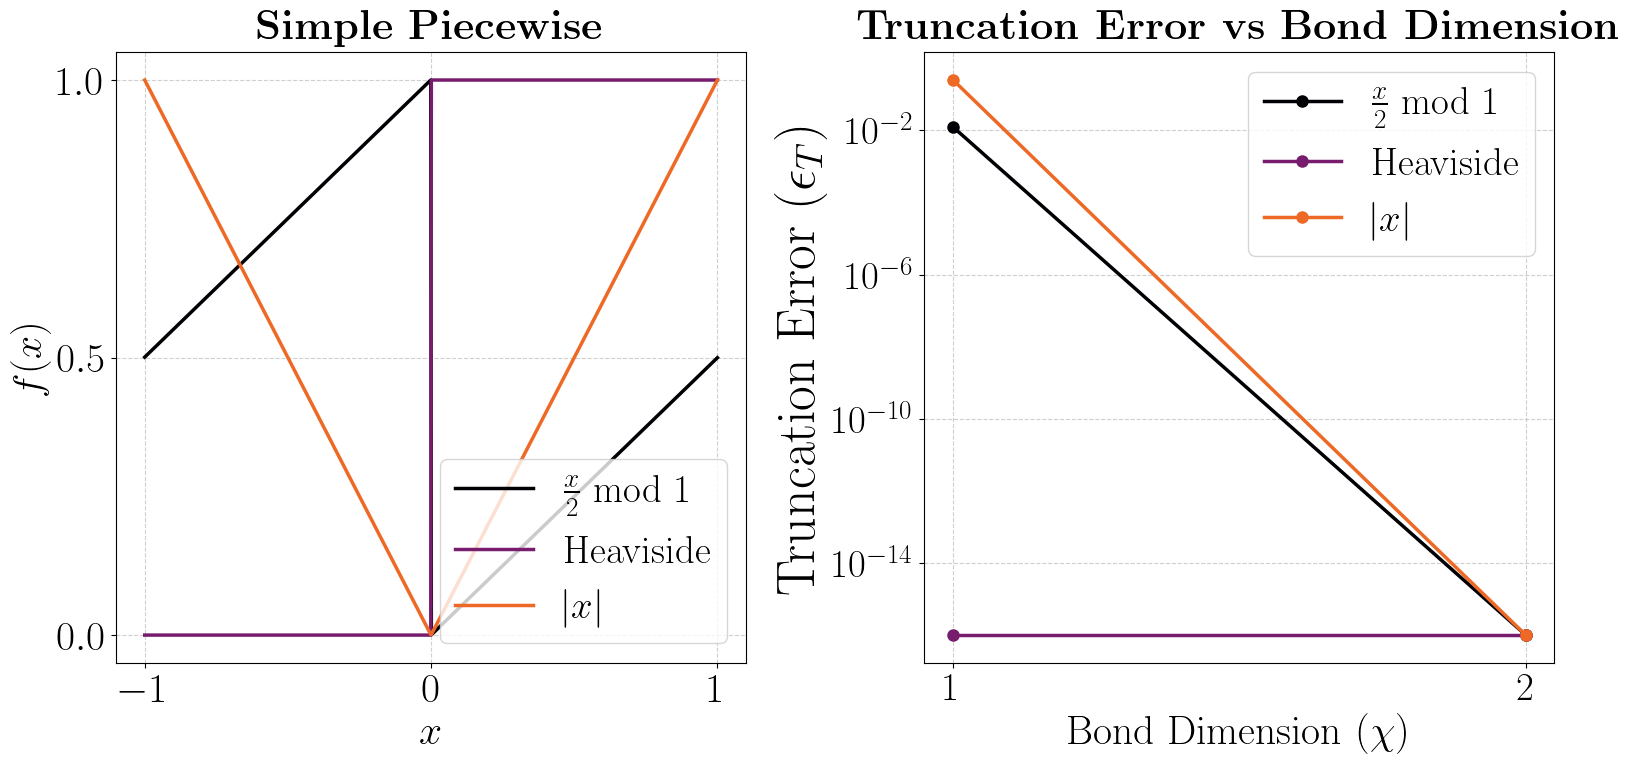

In [14]:
make_plots([r"$\frac{x}{2}$ mod 1","Heaviside",r"$|x|$",r"$\frac{x}{2}$ mod 1"], [1,2], h_data, heaviside_data, 'simple_piecewise.pdf',r'Simple Piecewise',loc1='lower right',y_ticks_1=[0.0,0.5,1.0],spacing=4)

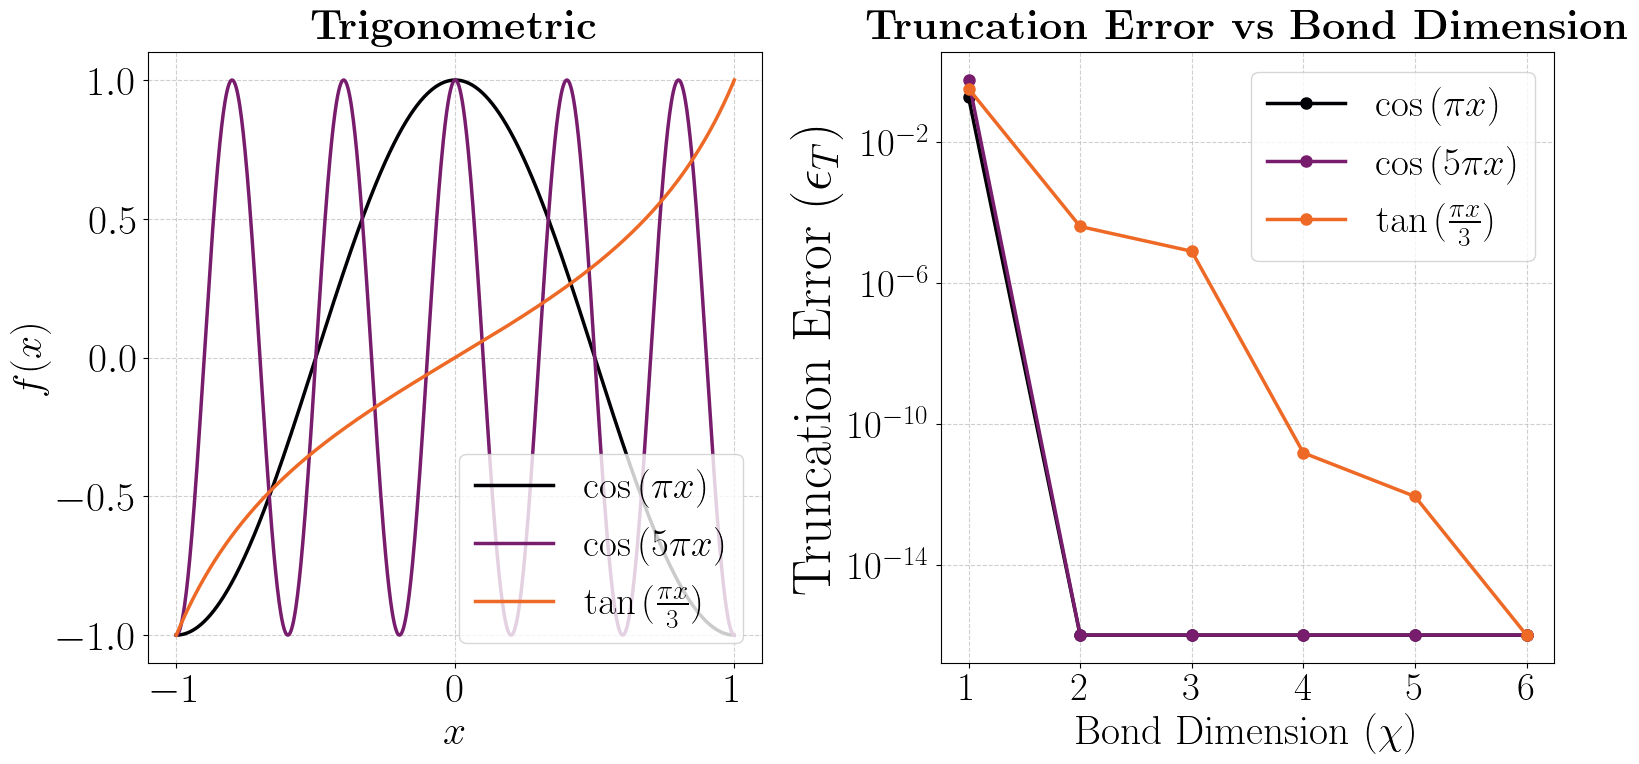

In [15]:
make_plots([r"$\cos{(\pi x)}$",r"$\cos{(5\pi x)}$",r"$\tan{(\frac{\pi x}{3})}$"], [1,2,3,4,5,6], c_data, cosine_data, 'trig.pdf',r'Trigonometric',loc1='lower right',spacing=4)

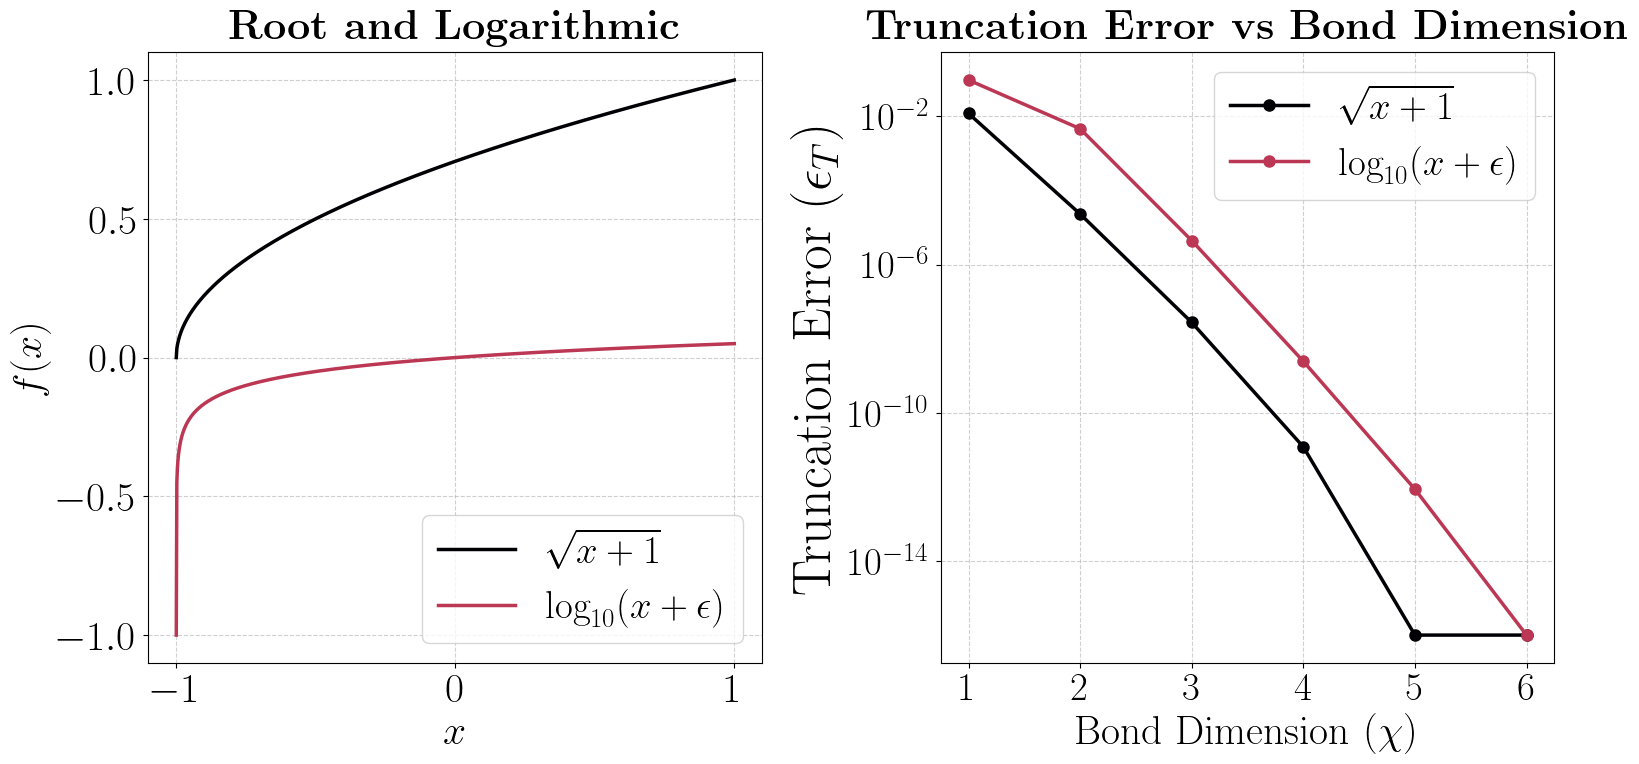

In [16]:
make_plots([r"$\sqrt{x+1}$",r"$\log_{10}(x+\epsilon)$"], [1,2,3,4,5,6], r_data, root_funcs, 'root_log.pdf',r'Root and Logarithmic',loc1='lower right',spacing=4)

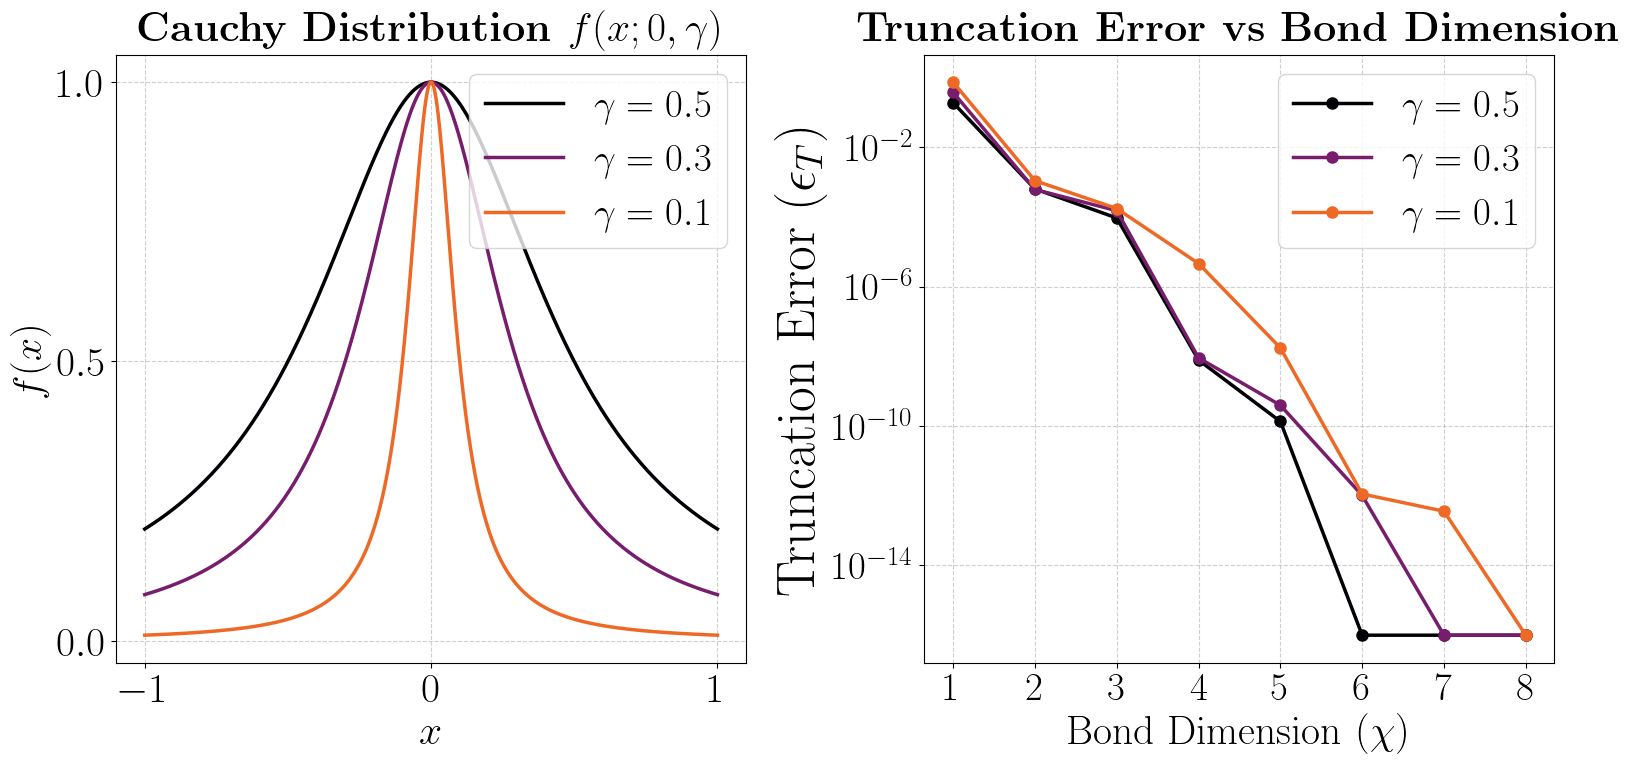

In [78]:
make_plots([r"$\gamma=0.5$",r"$\gamma=0.3$",r"$\gamma=0.1$"], [1,2,3,4,5,6,7,8], cpdf_data, cauchy_funcs, 'cauchy.pdf',r'Cauchy Distribution $f(x;0,\gamma)$',loc1='upper right',spacing=4,y_ticks_1=[0.0,0.5,1.0])

Uniform-Root Polynomials

In [18]:
#Compute polynomials with equally spaced roots in the domain of interest

def equally_spaced_roots_polynomial(d):
    if not isinstance(d, int) or d < 0:
        raise ValueError("Degree 'd' must be a non-negative integer.")

    if d == 0:
        # Degree 0: Constant polynomial 1
        return np.poly1d([1])
    elif d == 1:
        # Degree 1: Single root at 0
        roots = [0]
    else:
        # Degrees >=2: Equally spaced roots in [-1, 1]
        roots = np.linspace(-1, 1, d)
    
    # Generate polynomial coefficients from roots
    coefficients = np.poly(roots)
    
    # Create a polynomial object
    polynomial = np.poly1d(coefficients)
    
    return polynomial

In [19]:
degrees = [1,2,3,4,5,10]

uniform_polynomials_data = [equally_spaced_roots_polynomial(deg) for deg in degrees]

error_uniform_polynomials_data = get_bond_data(uniform_polynomials_data,n=16)


 
1 x
Exact mean fractional entropy = [0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136, 0.06872081137543136]
Approx mean fractional entropy = [1.2059629585870667e-15, 0.06872081137543154, 0.06872081137543228, 0.0687208113754312, 0.06872081137543143, 0.06872081137543123, 0.06872081137543123, 0.0687208113754317]
bond = 1 and fidelity = 0.7500000001746226
bond = 2 and fidelity = 0.9999999999999998
bond = 3 and fidelity = 0.9999999999999982
bond = 4 and fidelity = 1.0000000000000004
bond = 5 and fidelity = 1.0
bond = 6 and fidelity = 1.0000000000000009
bond = 7 and fidelity = 1.0000000000000009
bond = 8 and fidelity = 0.9999999999999993
   2
1 x - 1
Exact mean fractional entropy = [0.05400117837189755, 0.05400117837189755, 0.05400117837189755, 0.05400117837189755, 0.05400117837189755, 0.05400117837189755, 0.05400117837189755, 0.05400117837189755]
Approx mean fractional entropy = [2.18290634617

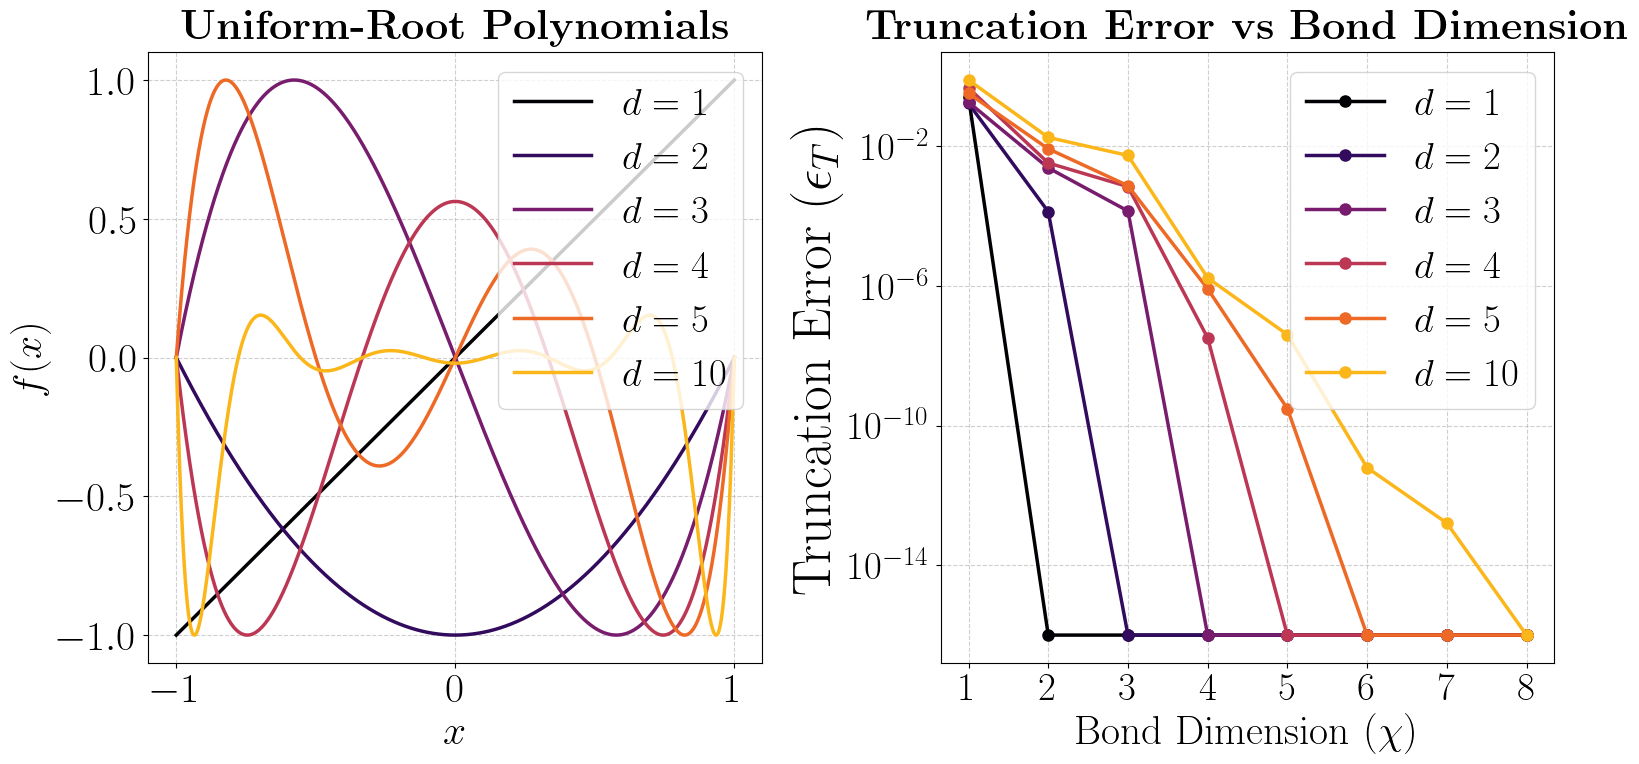

In [79]:
names = [rf"$d = {deg}$" for deg in degrees]
bond_dims = [1,2,3,4,5,6,7,8]

make_plots(names, bond_dims, error_uniform_polynomials_data, uniform_polynomials_data, 'new_uniform_polynomial_functions.pdf',r'Uniform-Root Polynomials',spacing=4)

Generation Piecewise Polynomials Functionality

In [21]:
def generate_random_piecewise_polynomial(domain, num_subintervals, degree_list, seed=None):
    """
    Generates a randomly piecewise polynomial function with continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree_list: list, degrees of polynomials for each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        degree = degree_list[i]  # Get the degree for this subinterval
        coeffs = np.random.randn(degree + 1)  # Random coefficients for polynomial of specified degree
        
        # Adjust constant term to ensure continuity
        # Evaluate polynomial at the left endpoint (knots[i]) and set it to prev_val
        x = knots[i]
        poly_val = np.polyval(coeffs[1:], x) if degree > 0 else 0  # a_n x^n + ... + a_1 x (ignore constant term)
        coeffs[-1] = prev_val - poly_val  # Set a_0 for continuity
        
        polynomials.append(coeffs)
        
        # Update prev_val to the value at the right endpoint
        x_next = knots[i + 1]
        prev_val = np.polyval(coeffs, x_next)
    
    def func(x):
        """
        Evaluates the piecewise polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for i in range(num_subintervals):
            mask = (x >= knots[i]) & (x <= knots[i + 1]) if i < num_subintervals - 1 else (x >= knots[i]) & (x <= knots[i + 1] + 1e-12)
            y[mask] = np.polyval(polynomials[i], x[mask])
        
        return y
    
    return func

from scipy.interpolate import CubicSpline

def generate_cubic_spline(domain, num_knots, seed=None):
    """
    Generates a cubic spline interpolant based on randomly sampled points.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_knots: int, number of knots (including endpoints)
    - seed: int or None, random seed for reproducibility

    Returns:
    - spline_func: callable, the cubic spline function
    - knots: numpy array, the knot points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_knots)
    
    # Generate random y-values for the knots
    y_vals = np.random.randn(num_knots)
    
    # Create cubic spline with natural boundary conditions
    cs = CubicSpline(knots, y_vals, bc_type='natural')
    
    def spline_func(x):
        return cs(x)
    
    return spline_func

from numpy.polynomial.chebyshev import chebval


def generate_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a piecewise Chebyshev polynomial function ensuring continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        # Coefficients are in the Chebyshev basis
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        # x_mapped = (2x - (b + a)) / (b - a)
        # Here, a = knots[i], b = knots[i+1]
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # To ensure continuity, adjust the constant term so that P(a) = prev_val
        # P(a) = chebval(-1, coeffs) = sum_{k=0}^degree c_k T_k(-1)
        # Compute sum_{k=0}^degree c_k T_k(-1)
        T = np.cos(np.pi * np.arange(degree +1))  # T_k(-1) = (-1)^k
        poly_at_a = np.dot(coeffs, T)
        coeffs_adjusted = coeffs.copy()
        coeffs_adjusted[0] += prev_val - poly_at_a  # Adjust c0
        
        polynomials.append((coeffs_adjusted, knots[i], knots[i+1]))
        
        # Update prev_val to P(b)
        # P(b) = chebval(1, coeffs) = sum_{k=0}^degree c_k T_k(1) = c0 + c1 + ... + c_degree
        poly_at_b = np.dot(coeffs_adjusted, np.ones(degree +1))  # T_k(1) = 1
        prev_val = poly_at_b
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func

def generate_discontinuous_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a discontinuous piecewise Chebyshev polynomial function.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # Store the polynomial for the current subinterval
        polynomials.append((coeffs, knots[i], knots[i+1]))
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func

Compute Truncation Errors

In [ ]:
d = [1,2,3,8]

d_pp_cheby = [generate_discontinuous_piecewise_chebyshev((-1,1), num_subintervals=5, degree=deg,seed=42) for deg in d]

d_pp_cheby_data = get_bond_data(d_pp_cheby,n=16)

In [27]:
d = [1,2,3,8]

d_pp_cheby = [generate_discontinuous_piecewise_chebyshev((-1,1), num_subintervals=5, degree=deg,seed=42) for deg in d]

d_pp_cheby_data = get_bond_data(d_pp_cheby,n=16)

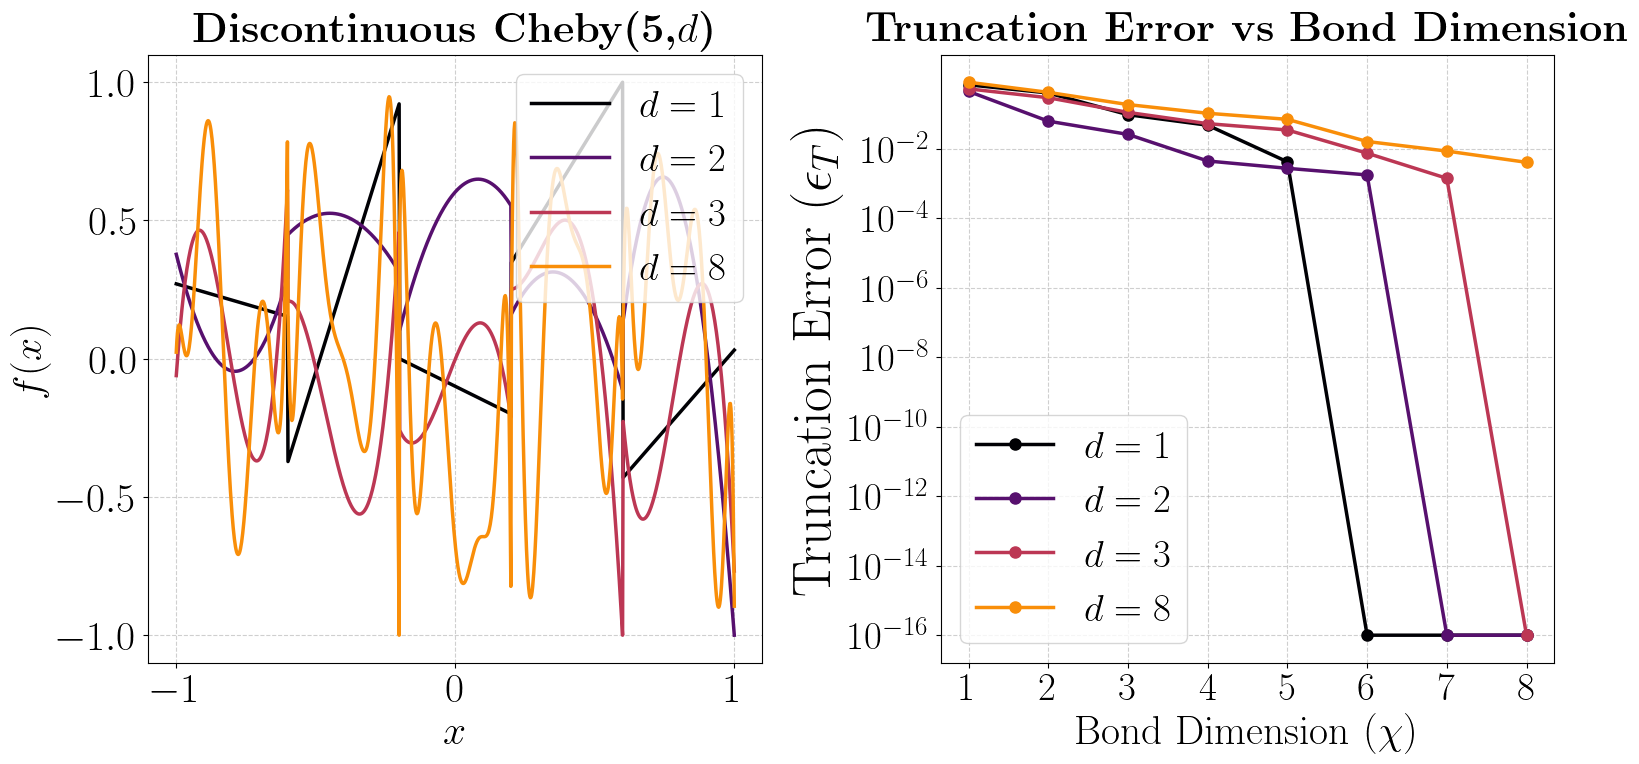

In [31]:
make_plots([r"$d=1$", r"$d=2$", r"$d=3$", r"$d=8$"], [1,2,3,4,5,6,7,8,], d_pp_cheby_data, d_pp_cheby, 'disc_piecewise.pdf',r'Discontinuous Cheby(5,$d$)',loc1='upper right',loc2='lower left')

In [32]:
max_deg = [1,2,3,4]

random_piecewise_funcs = [generate_random_piecewise_polynomial([-1,1], 5, degree_list=[deg]*5) for deg in max_deg]

error_random_piecewise_funcs_data = get_bond_data(random_piecewise_funcs,n=16)

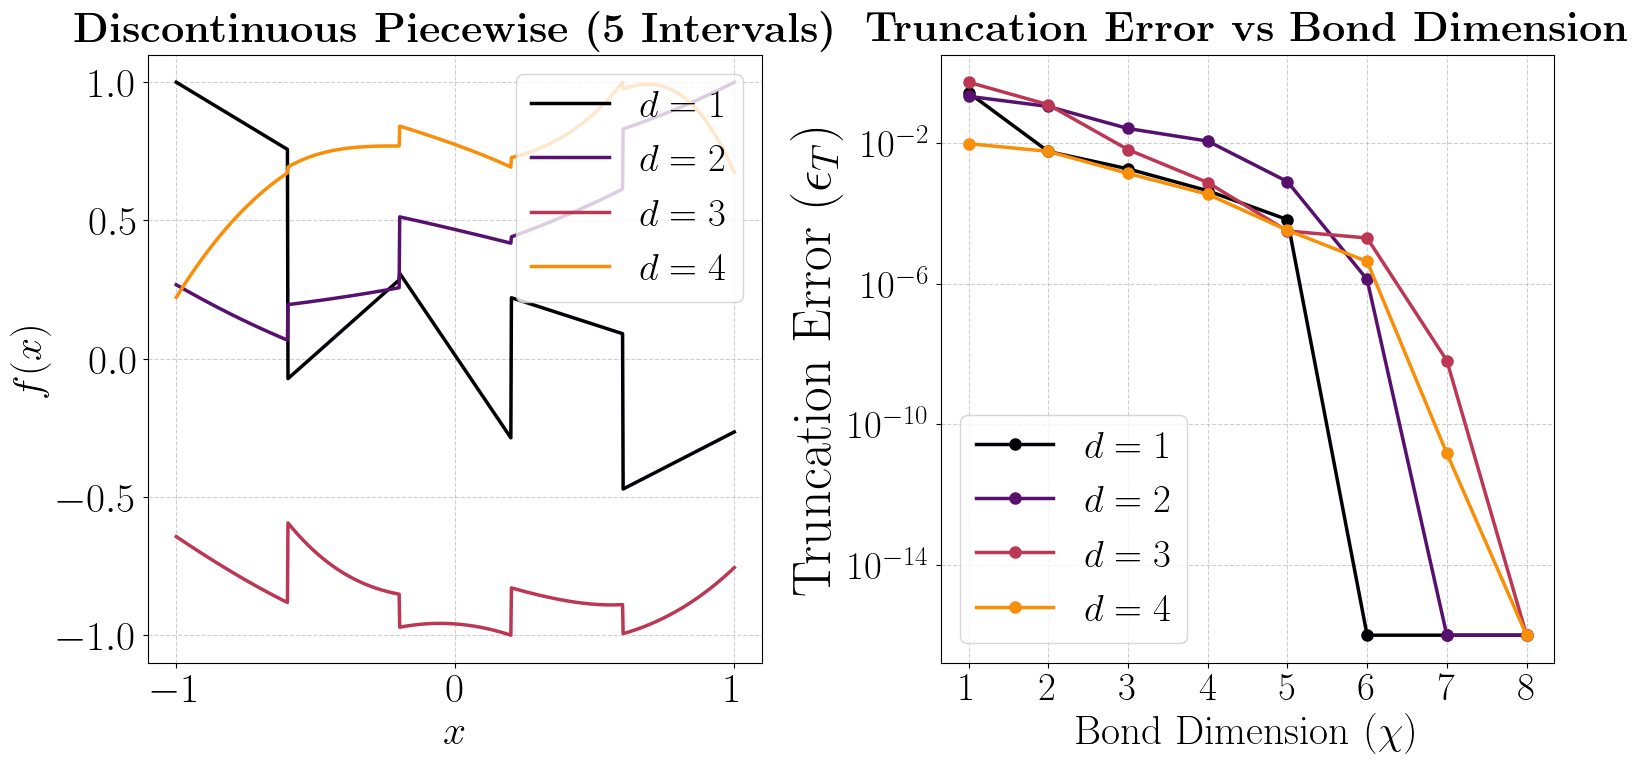

In [37]:
make_plots([r"$d=1$", r"$d=2$", r"$d=3$", r"$d=4$"], [1,2,3,4,5,6,7,8], error_random_piecewise_funcs_data, random_piecewise_funcs, 'disc_piecewise.pdf',r'Discontinuous Piecewise (5 Intervals)',loc1='upper right',spacing=4,loc2='lower left')

In [35]:
max_deg = [1,2,3,4]

random_piecewise_funcs10 = [generate_random_piecewise_polynomial([-1,1], 10, degree_list=[deg]*10) for deg in max_deg]

error_random_piecewise_funcs_data10 = get_bond_data(random_piecewise_funcs10,n=16)

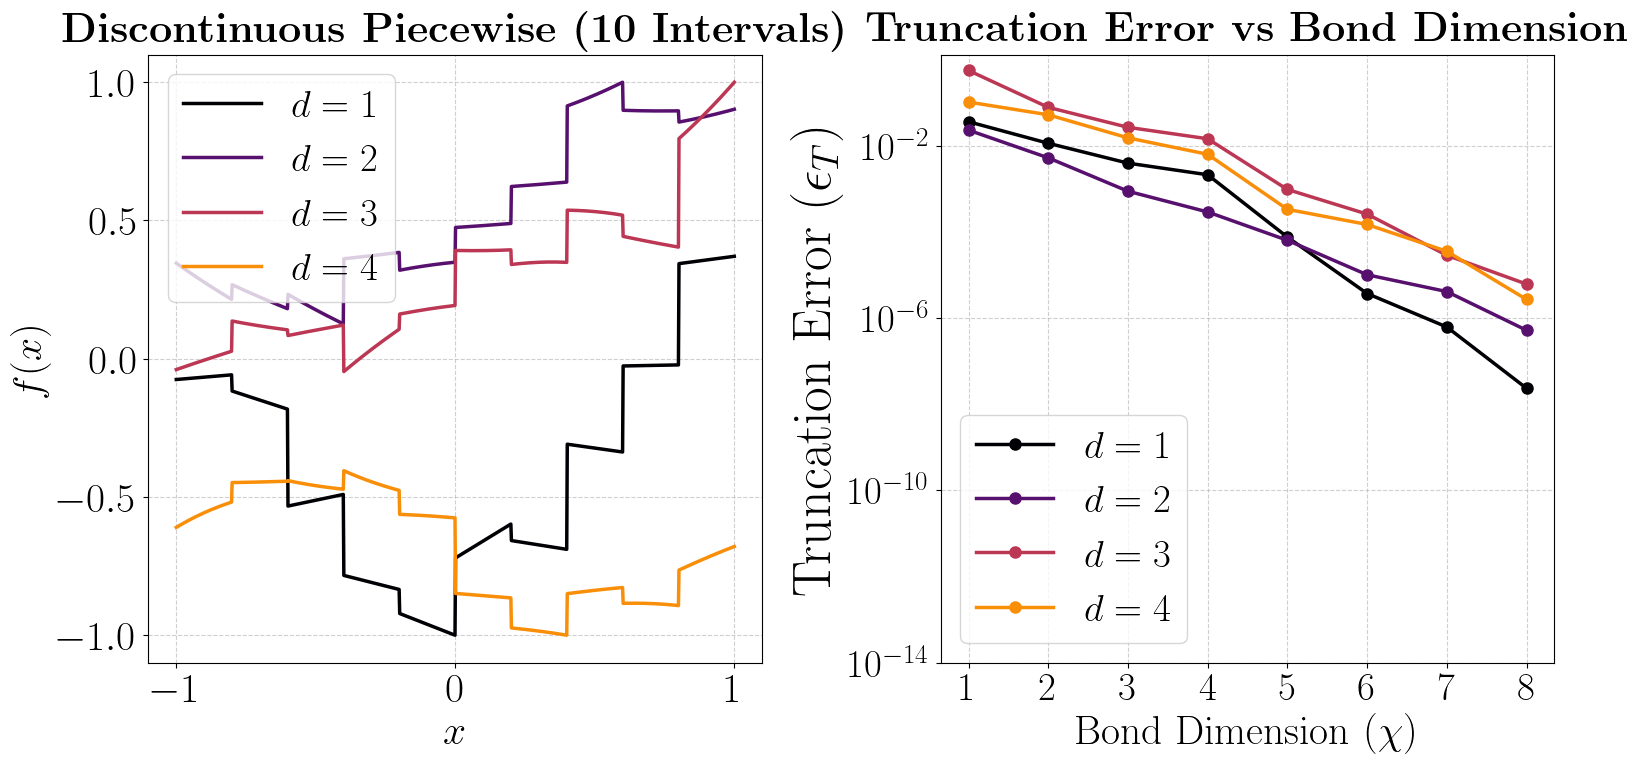

In [39]:
make_plots([r"$d=1$", r"$d=2$", r"$d=3$", r"$d=4$"], [1,2,3,4,5,6,7,8], error_random_piecewise_funcs_data10, random_piecewise_funcs10, 'disc_piecewise10.pdf',r'Discontinuous Piecewise (10 Intervals)',loc1='upper left',loc2='lower left',spacing=4)

In [40]:
import numpy as np

def generate_discontinuous_piecewise_linear(domain, num_subintervals, discontinuity_level, seed=None):
    """
    Generates a piecewise linear function with controlled discontinuity.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - discontinuity_level: int, from 0 (continuous) to 4 (maximum discontinuities)
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise linear function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    assert 0 <= discontinuity_level <= 4, "discontinuity_level must be between 0 and 4"
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Determine the factor to scale the discontinuity level
    discontinuity_factor = discontinuity_level / 4.0  # Scales between 0 (no discontinuity) and 1 (maximum discontinuity)
    
    # Initialize previous value for continuity or discontinuity adjustment
    prev_val = 0
    
    for i in range(num_subintervals):
        # Degree is 1 for linear polynomials
        degree = 1
        coeffs = np.random.randn(degree + 1)  # Random coefficients for the linear polynomial (ax + b)
        
        if discontinuity_level == 0:
            # If no discontinuity, adjust constant term to ensure continuity
            x = knots[i]
            poly_val = np.polyval(coeffs[1:], x)  # Just the linear term a*x
            coeffs[-1] = prev_val - poly_val  # Adjust b to ensure continuity
        else:
            # For discontinuity, we randomly adjust the start point of the next polynomial
            # based on the discontinuity factor
            discontinuity_shift = discontinuity_factor * np.random.randn()  # Random shift for discontinuity
            coeffs[-1] = prev_val + discontinuity_shift  # Adjust b with discontinuity factor
            
        polynomials.append(coeffs)
        
        # Update prev_val to the value at the right endpoint (next knot)
        x_next = knots[i + 1]
        prev_val = np.polyval(coeffs, x_next)
    
    def func(x):
        """
        Evaluates the piecewise linear function at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for i in range(num_subintervals):
            mask = (x >= knots[i]) & (x <= knots[i + 1]) if i < num_subintervals - 1 else (x >= knots[i]) & (x <= knots[i + 1] + 1e-12)
            y[mask] = np.polyval(polynomials[i], x[mask])
        
        return y
    
    return func


In [189]:
d_level = [1,2,3,4]

d_pw_funcs = [generate_discontinuous_piecewise_linear([-1,1], 5, discontinuity_level=d) for d in d_level]

d_pw_error = get_bond_data(d_pw_funcs,n=16)

<function generate_discontinuous_piecewise_linear.<locals>.func at 0x0000025DC400DA68>


KeyboardInterrupt: 

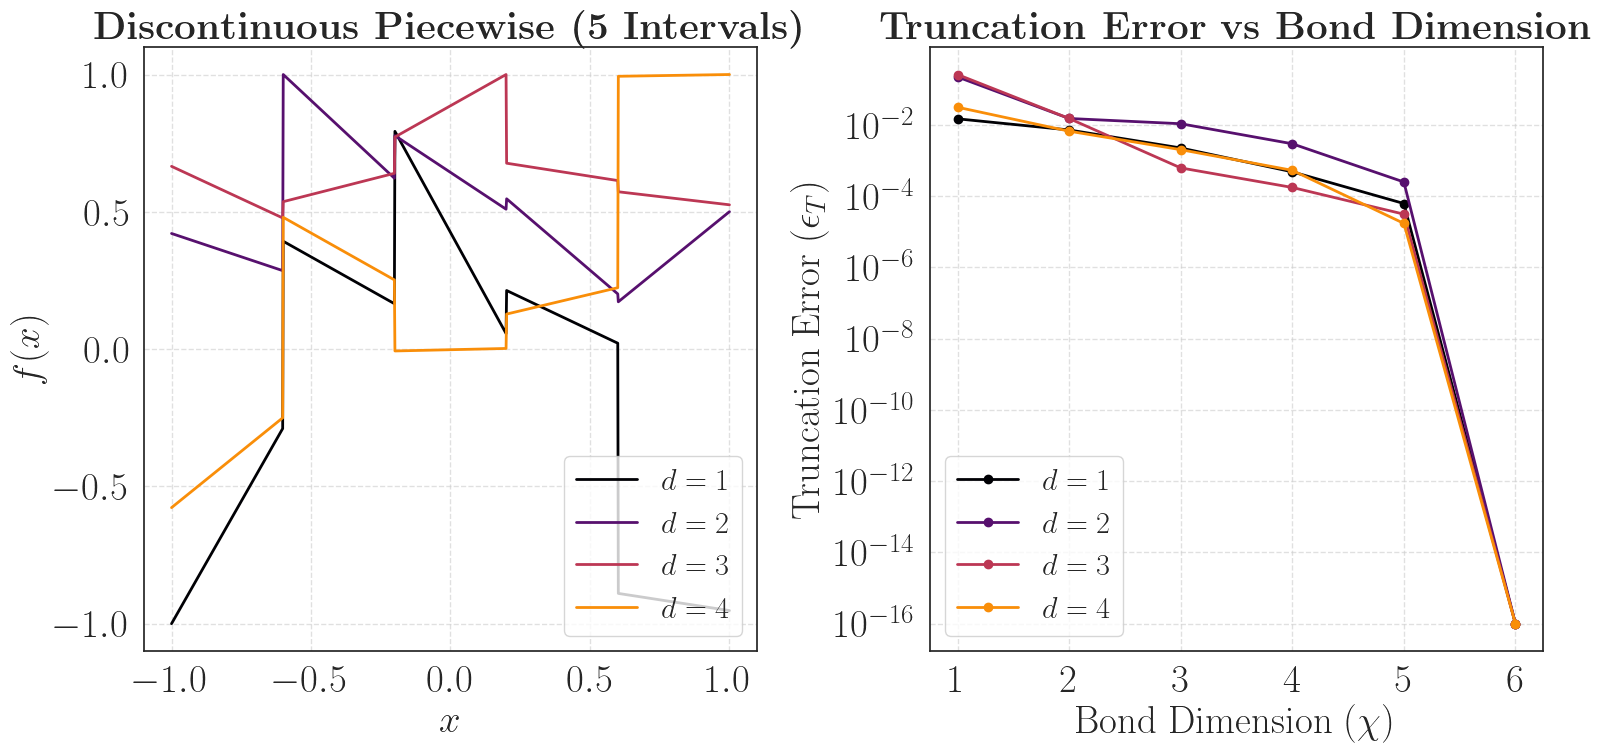

In [211]:
make_plots([r"$d=1$", r"$d=2$", r"$d=3$", r"$d=4$"], [1,2,3,4,5,6], d_pw_error, d_pw_funcs, 'new_disc_pp.png',r'Discontinuous Piecewise (5 Intervals)',loc1='lower right',loc2='lower left')

In [41]:
knots = [5,10,15,20]

generated_cubic_splines = [generate_cubic_spline([-1,1], knot) for knot in knots]

error_cubic_splines = get_bond_data(generated_cubic_splines,n=16)

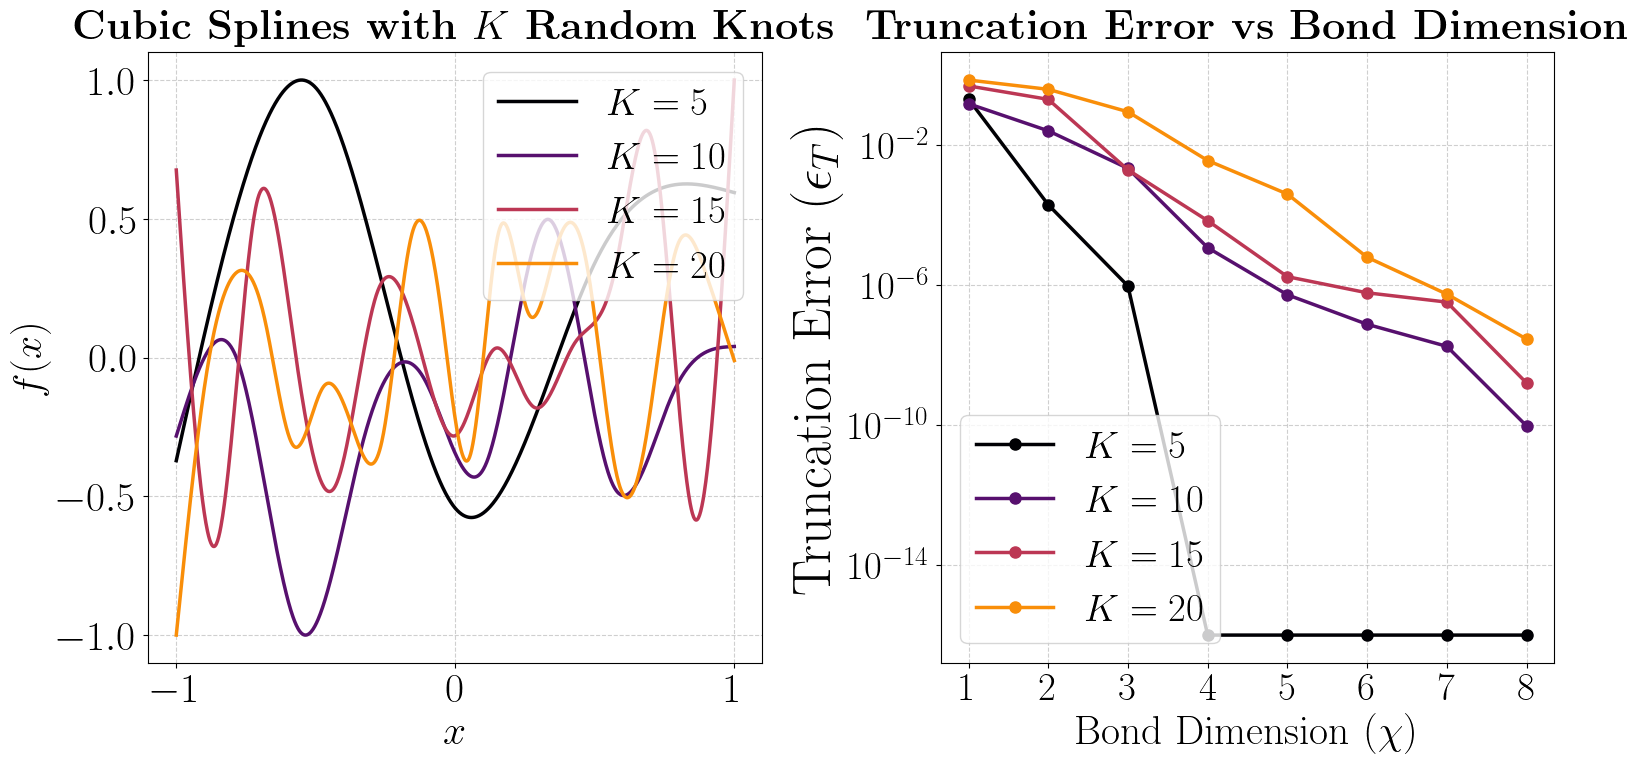

In [48]:
names = [rf"$Num Random Knots = {knot}$" for knot in knots]
bond_dims = [1,2,3,4,5,6,7,8]

make_plots([r"$K=5$",r"$K=10$",r"$K=15$",r"$K=20$"], bond_dims, error_cubic_splines, generated_cubic_splines, 'new_cubic_splines.pdf',r'Cubic Splines with $K$ Random Knots',y_tick_low=17,y_tick_high=2,loc1='upper right',loc2='lower left',spacing=4)

In [46]:
max_deg = [1,2,3,4]

cheb_funcs5 = [generate_piecewise_chebyshev((-1,1), 5, deg) for deg in max_deg]

cheb_errors5 = get_bond_data(cheb_funcs5,n=16)

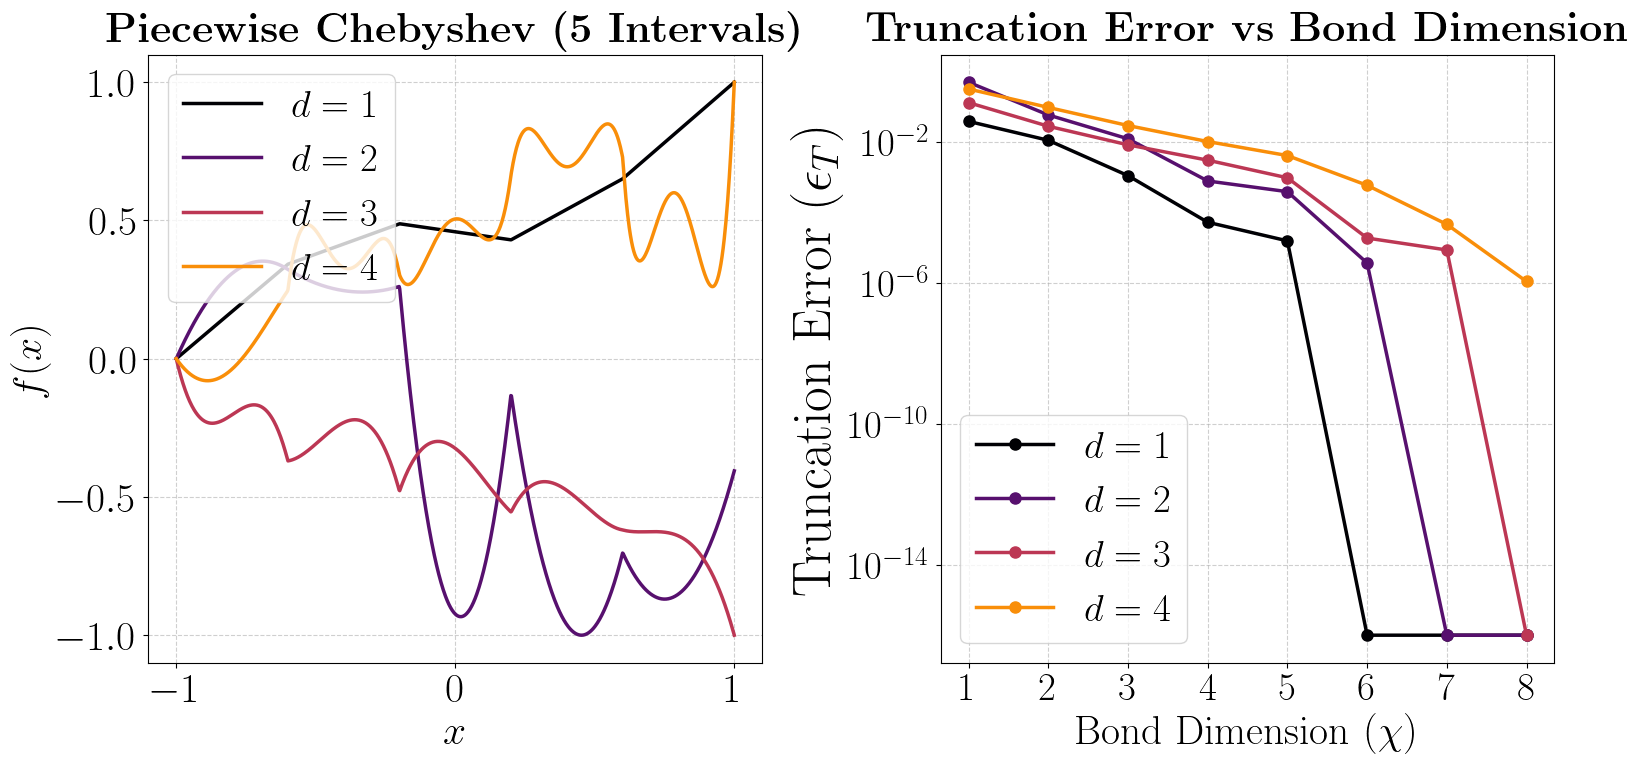

In [50]:
names = [rf"$max(d) = {deg}$" for deg in max_deg]
bond_dims = [1,2,3,4,5,6,7,8]

make_plots([r"$d=1$",r"$d=2$",r"$d=3$",r"$d=4$"], bond_dims, cheb_errors5, cheb_funcs5, 'low_deg_cheby5.pdf',r'Piecewise Chebyshev (5 Intervals)',y_tick_low=17,y_tick_high=2,loc1='upper left',loc2='lower left',spacing=4)

In [51]:
max_deg = [1,2,3,4]

cheb_funcs = [generate_piecewise_chebyshev((-1,1), 10, deg) for deg in max_deg]

cheb_errors = get_bond_data(cheb_funcs,n=16)

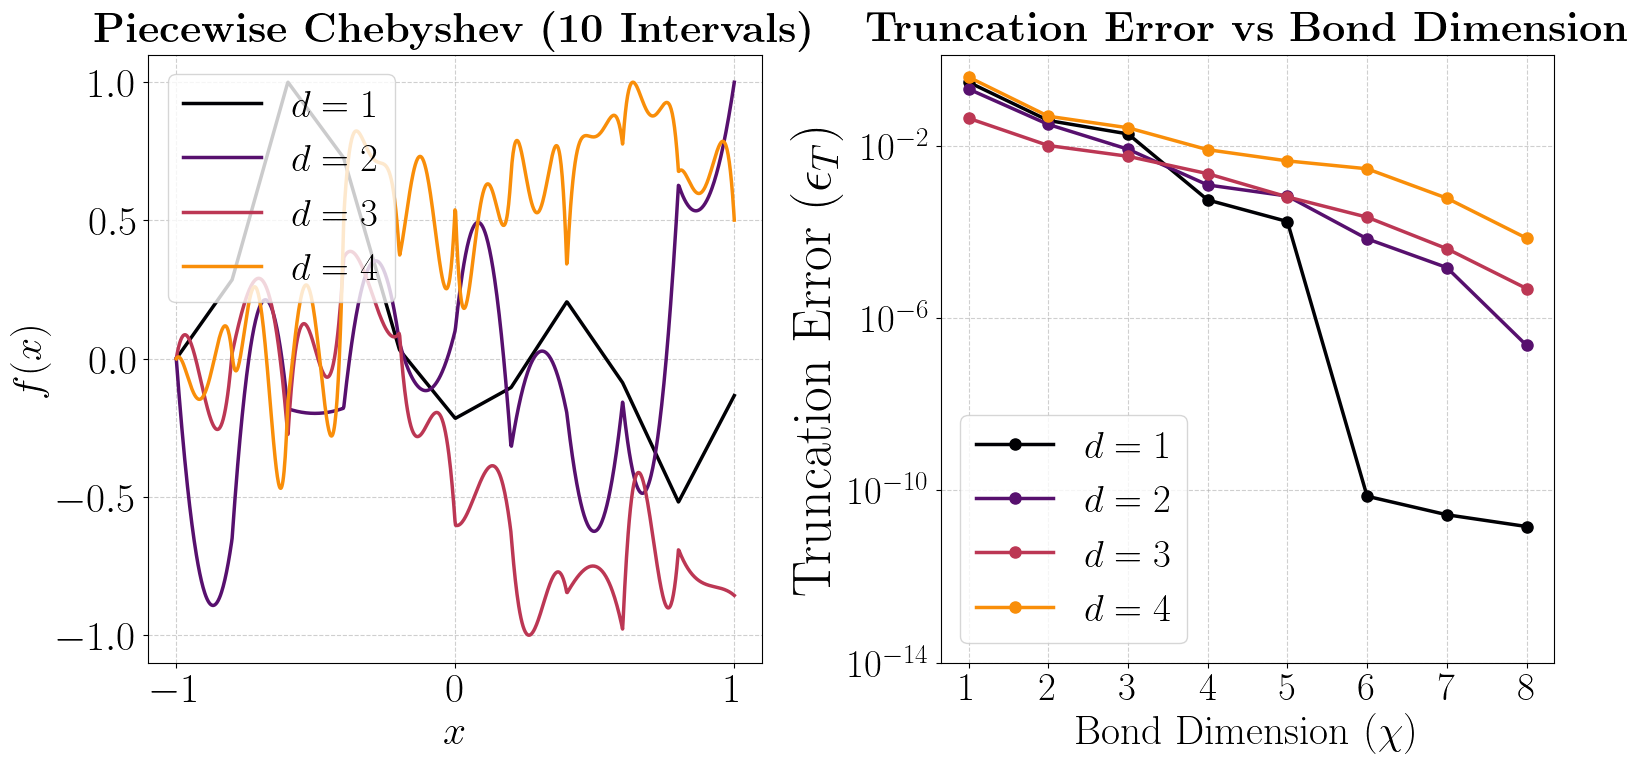

In [54]:
names = [rf"$max(d) = {deg}$" for deg in max_deg]
bond_dims = [1,2,3,4,5,6,7,8]

make_plots([r"$d=1$",r"$d=2$",r"$d=3$",r"$d=4$"], bond_dims, cheb_errors, cheb_funcs, 'low_deg_cheby10.pdf',r'Piecewise Chebyshev (10 Intervals)',y_tick_low=17,y_tick_high=2,loc1='upper left',loc2='lower left',spacing=4)

In [56]:
max_deg = [5,10,15,20]

cheb_funcs_high = [generate_piecewise_chebyshev((-1,1), 10, deg) for deg in max_deg]

cheb_errors_high = get_bond_data(cheb_funcs_high,n=16)

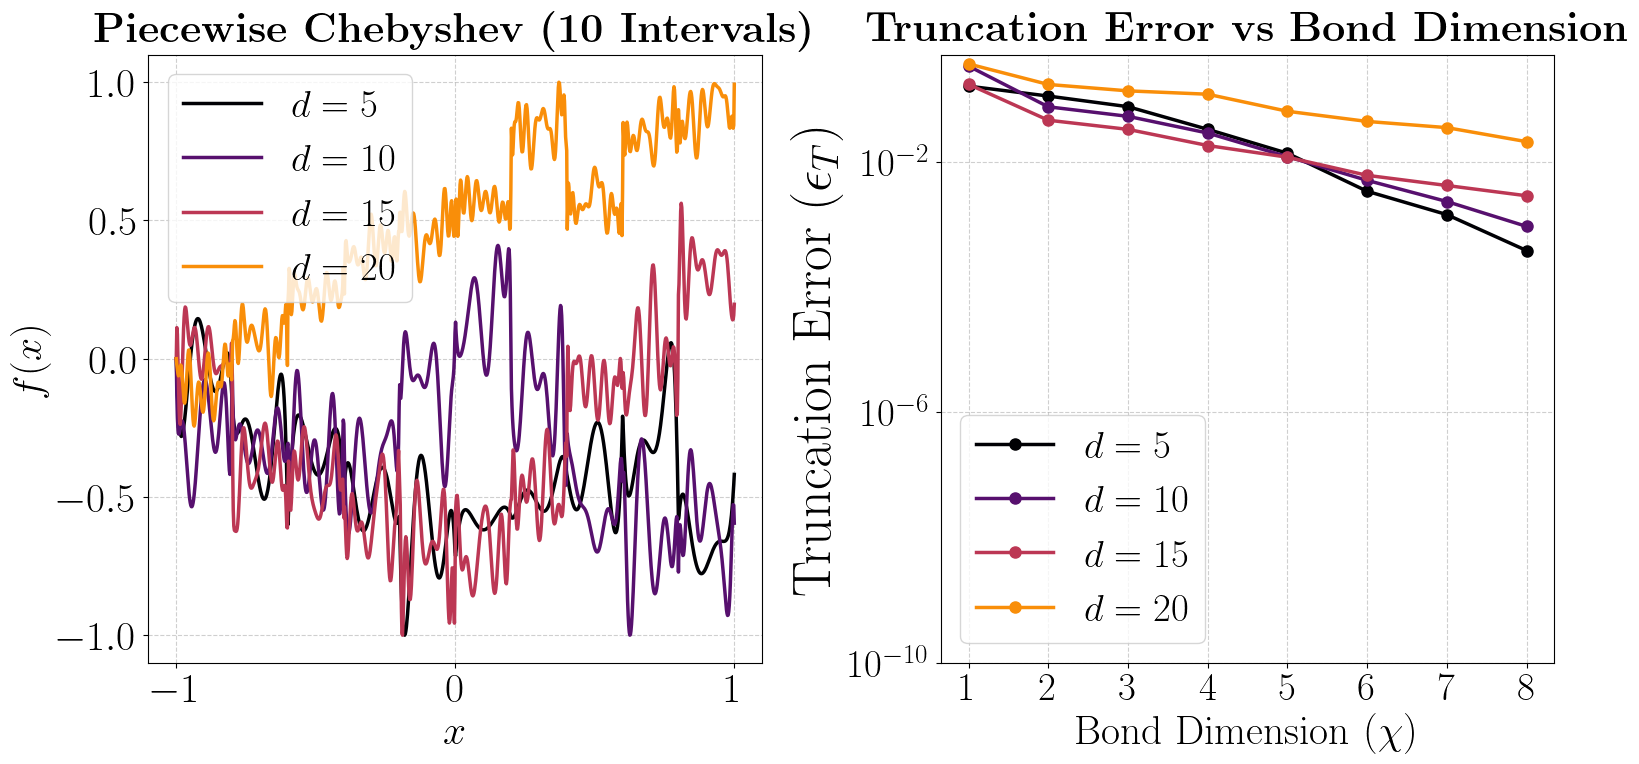

In [57]:
names = [rf"$max(d) = {deg}$" for deg in max_deg]
bond_dims = [1,2,3,4,5,6,7,8]

make_plots([r"$d=5$",r"$d=10$",r"$d=15$",r"$d=20$"], bond_dims, cheb_errors_high, cheb_funcs_high, 'high_deg_cheby10.pdf',r'Piecewise Chebyshev (10 Intervals)',y_tick_low=13,y_tick_high=2,loc1='upper left',loc2='lower left',spacing=4)

In [72]:
max_deg = [5,10,15,20]

cheb_funcs_high5 = [generate_piecewise_chebyshev((-1,1), 5, deg) for deg in max_deg]

cheb_errors_high5 = get_bond_data(cheb_funcs_high,n=16)

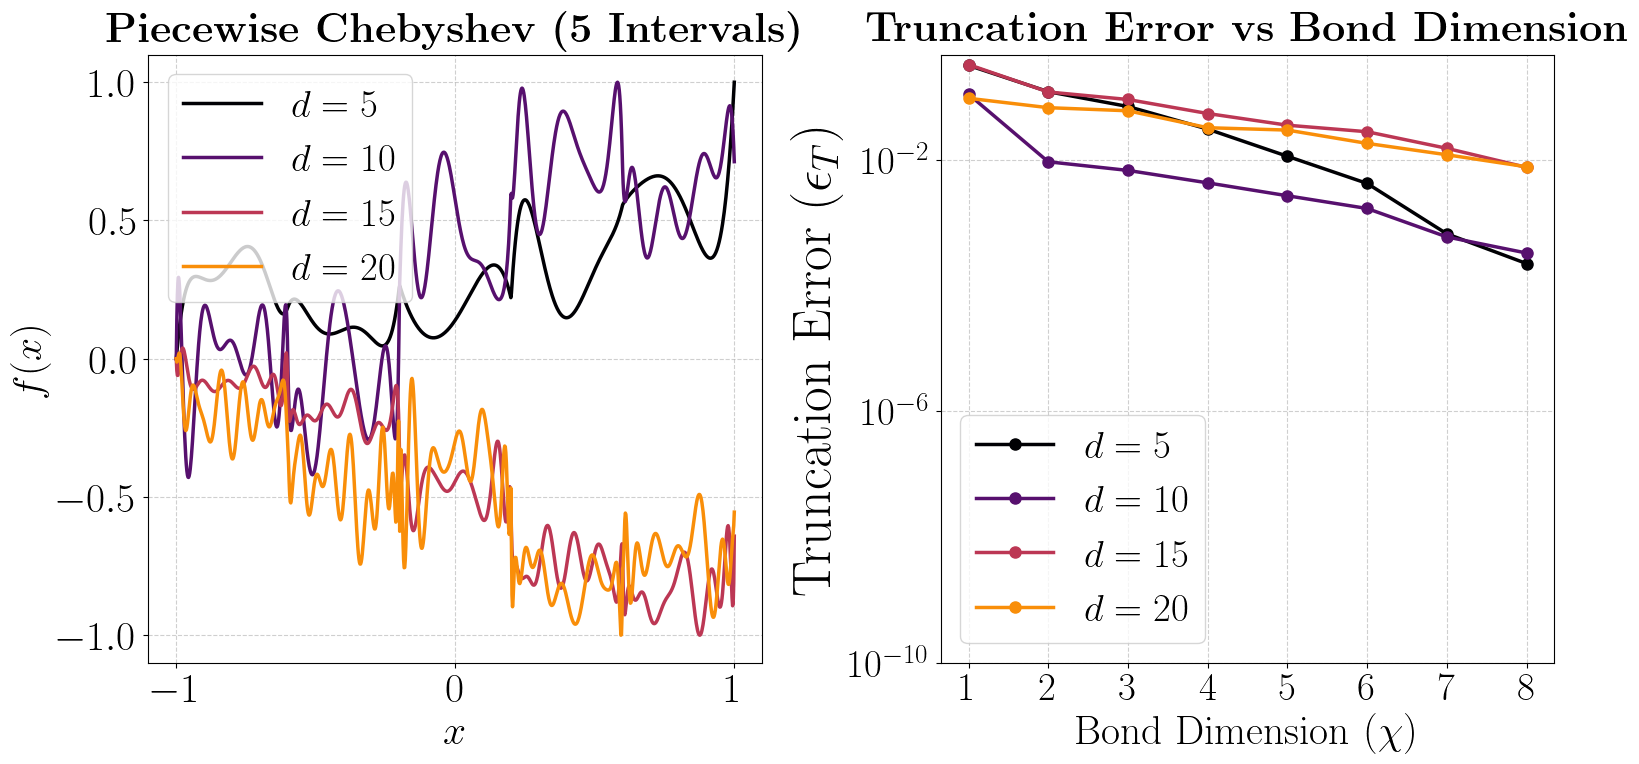

In [74]:
names = [rf"$max(d) = {deg}$" for deg in max_deg]
bond_dims = [1,2,3,4,5,6,7,8]

make_plots([r"$d=5$",r"$d=10$",r"$d=15$",r"$d=20$"], bond_dims, cheb_errors_high5, cheb_funcs_high5, 'high_deg_cheby5.pdf',r'Piecewise Chebyshev (5 Intervals)',y_tick_low=13,y_tick_high=2,loc1='upper left',loc2='lower left',spacing=4)

#### GAUSSIAN DATA

In [ ]:
#SCALING

max_deg = [4]

scaling_cheby_poly = [generate_piecewise_chebyshev((-1,1), 5, deg)[0] for deg in max_deg]

error_scaling_cheby = []

for n in [8,16,24,32,40]:
    error_n = get_bond_data(scaling_cheby_poly,n=n)
    error_scaling_cheby.append(error_n[0])

Gaussian Data

In [268]:
filtered_s_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

gauss = lambda x, std: (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / std) ** 2)

gausses = [lambda x, std=std: gauss(x, std) for std in filtered_s_values]

gausses_errors = get_bond_data(gausses,n=15)

<function <listcomp>.<lambda> at 0x0000025DC4A68798>
bond = 1 and fidelity = 0.5308093813098758
bond = 2 and fidelity = 0.9979250088113991
bond = 3 and fidelity = 0.9997257920045247
bond = 4 and fidelity = 0.999999976400635
bond = 5 and fidelity = 0.999999999865812
bond = 6 and fidelity = 0.9999999999997295
bond = 7 and fidelity = 0.9999999999999993
bond = 8 and fidelity = 1.0000000000000013
<function <listcomp>.<lambda> at 0x0000025DC4A68168>
bond = 1 and fidelity = 0.6917447759879953
bond = 2 and fidelity = 0.9977916359566854
bond = 3 and fidelity = 0.9999451346954332
bond = 4 and fidelity = 0.9999999989096502
bond = 5 and fidelity = 0.9999999999982345
bond = 6 and fidelity = 0.9999999999999989
bond = 7 and fidelity = 1.0000000000000009
bond = 8 and fidelity = 1.0000000000000022
<function <listcomp>.<lambda> at 0x0000025DC4A68438>
bond = 1 and fidelity = 0.811194579558654
bond = 2 and fidelity = 0.9993090988100962
bond = 3 and fidelity = 0.9999912881618593
bond = 4 and fidelity = 0.9

In [80]:
gausses_errors = [{1: 0.5308093813098758, 2: 0.9979250088113991, 3: 0.9997257920045247, 4: 0.999999976400635, 5: 0.999999999865812, 6: 0.9999999999997295, 7: 0.9999999999999993, 8: 1.0000000000000013}, {1: 0.6917447759879953, 2: 0.9977916359566854, 3: 0.9999451346954332, 4: 0.9999999989096502, 5: 0.9999999999982345, 6: 0.9999999999999989, 7: 1.0000000000000009, 8: 1.0000000000000022}, {1: 0.811194579558654, 2: 0.9993090988100962, 3: 0.9999912881618593, 4: 0.9999999998905698, 5: 0.9999999999999554, 6: 1.0000000000000004, 7: 1.0000000000000009, 8: 0.9999999999999993}, {1: 0.8862085802880364, 2: 0.9997094007136937, 3: 0.999998996156033, 4: 0.9999999999916973, 5: 0.9999999999999978, 6: 1.0000000000000018, 7: 1.0000000000000022, 8: 1.0000000000000027}, {1: 0.9301511154817177, 2: 0.9998661496623287, 3: 0.9999998252615082, 4: 0.9999999999992251, 5: 1.0000000000000009, 6: 0.9999999999999991, 7: 1.0000000000000009, 8: 1.0000000000000009}, {1: 0.9557234544510108, 2: 0.9999622037390363, 3: 0.9999999633607864, 4: 0.9999999999999276, 5: 1.0000000000000018, 6: 1.000000000000003, 7: 1.000000000000003, 8: 1.0000000000000036}, {1: 0.9709338829682185, 2: 0.9999813884670878, 3: 0.9999999905746062, 4: 0.999999999999986, 5: 1.0000000000000009, 6: 1.0000000000000022, 7: 1.0000000000000022, 8: 1.0000000000000018}, {1: 0.9802728589924157, 2: 0.9999936582861748, 3: 0.9999999974605844, 4: 0.9999999999999958, 5: 1.0000000000000027, 6: 1.0000000000000004, 7: 1.0000000000000018, 8: 1.0000000000000018}]


In [81]:
gausses_errors[4][5]=1
gausses_errors[4][6]=1

c:\Users\0josh\miniconda3\envs\mps_env1\lib\site-packages\ipykernel_launcher.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


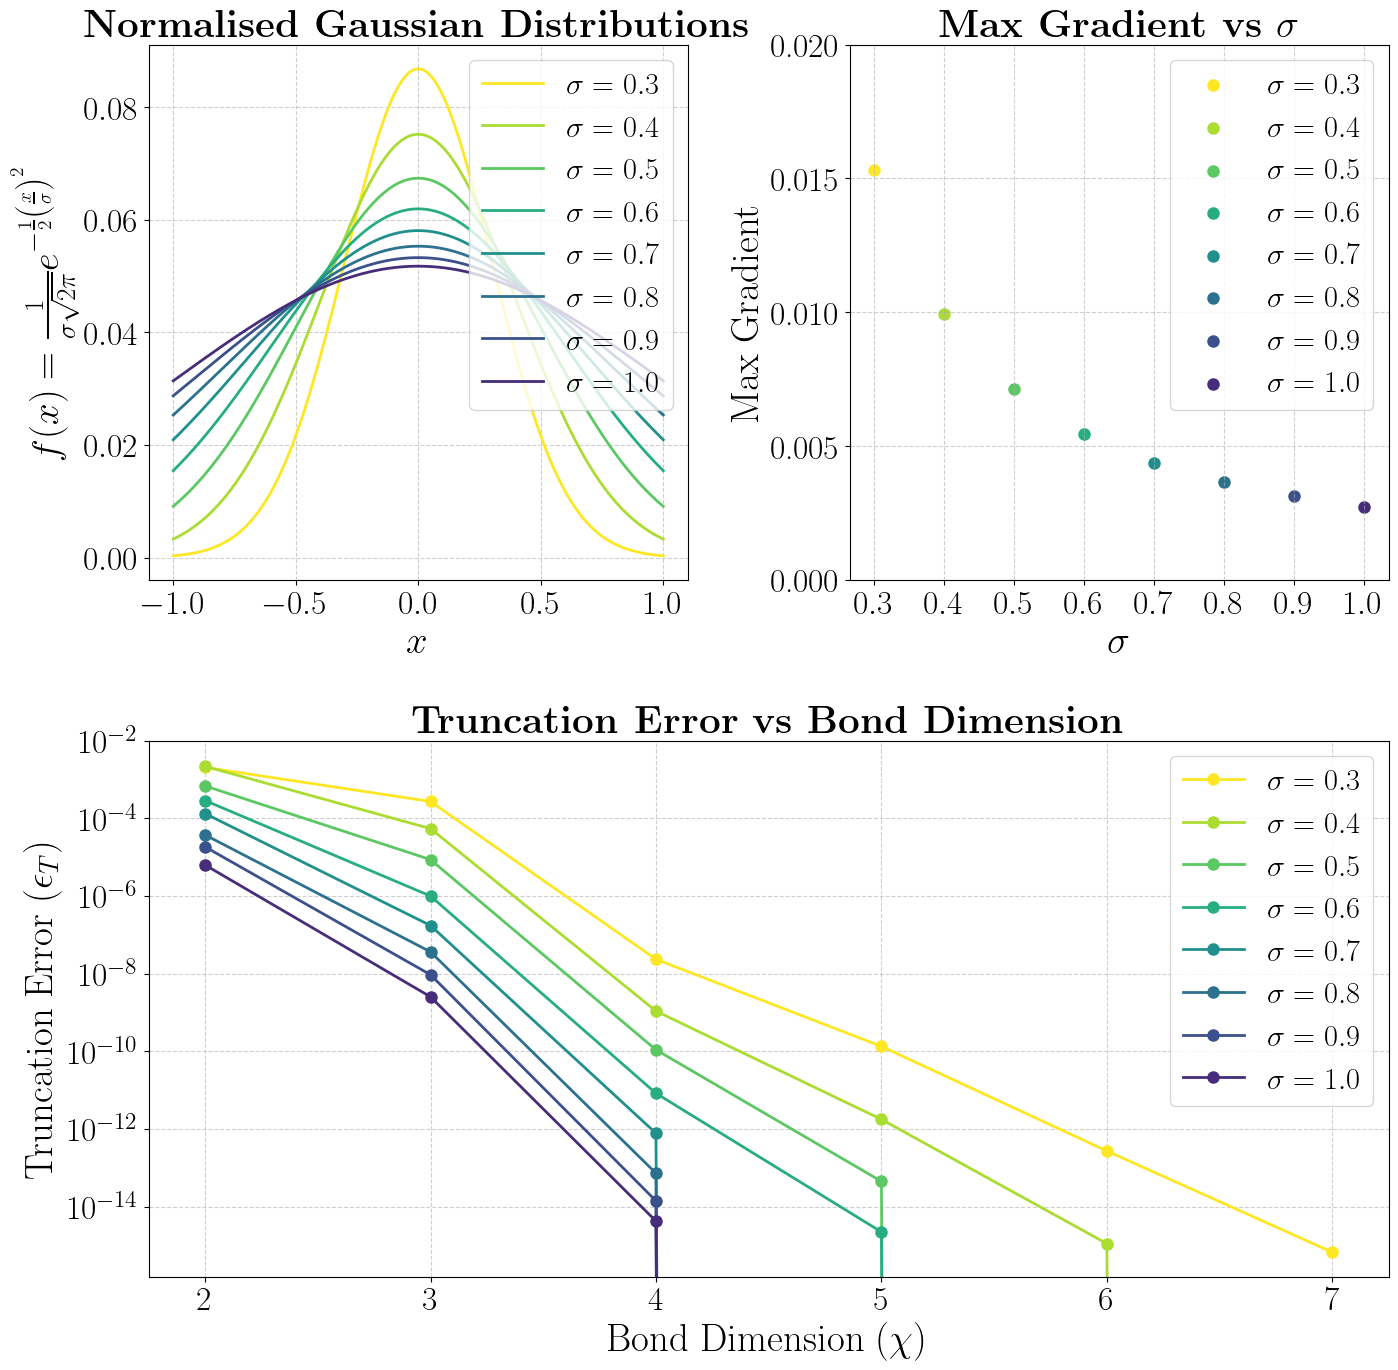

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter, FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# -------------------------------
# Your Actual Data Definitions
# -------------------------------
filtered_max_gradients = [
    0.015316596805035942, 0.009950433848146645, 0.007135207911879604,
    0.005465803141333936, 0.004393591857528634, 0.0036612572219425488,
    0.003135287467557646, 0.002741607649956034
]
bond_dimensions = [2, 3, 4, 5, 6, 7]
filtered_data = gausses_errors  # Ensure gausses_errors is defined in your environment
filtered_s_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1.0]

# -------------------------------
# Configure LaTeX Fonts and Font Sizes
# -------------------------------
plt.rcParams.update({
    "text.usetex": True,                # Enable LaTeX rendering
    "font.family": "serif",             # Use serif fonts
    "font.serif": ["Computer Modern"],  # Use Computer Modern for LaTeX consistency
    "axes.labelsize": 28,               # Axis label font size
    "axes.titlesize": 28,               # Title font size
    "xtick.labelsize": 24,              # X-axis tick label size
    "ytick.labelsize": 24,              # Y-axis tick label size
    "legend.fontsize": 22,              # Legend font size
    "legend.title_fontsize": 22,        # Legend title font size
    "lines.linewidth": 2,               # Default line width
    "lines.markersize": 8,              # Default marker size
})

# -------------------------------
# Prepare Colors using Inferno Colormap
# -------------------------------
cmap = plt.get_cmap('viridis_r')  # Use 'inferno' colormap for distinct colors
colors = [cmap(i / len(filtered_s_values)) for i in range(len(filtered_s_values))]

# -------------------------------
# Create the Subplots with GridSpec
# -------------------------------
fig = plt.figure(figsize=(16, 16))  # Adjusted figure size for better readability
gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    hspace=0.3,  # Increased vertical spacing
    wspace=0.3   # Increased horizontal spacing
)

# Define subplot axes
ax_gaussian = fig.add_subplot(gs[0, 0])      # Top-left
ax_max_grad = fig.add_subplot(gs[0, 1])      # Top-right
ax_infidelity = fig.add_subplot(gs[1, :])    # Bottom spanning both columns

# -------------------------------
# Plot 1: Normalized Gaussian Distributions
# -------------------------------
x = np.linspace(-1, 1, 500)
for s, color in zip(filtered_s_values, colors):
    # Compute the normalized Gaussian
    y = (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-x**2 / (2 * s**2))
    y = y / np.linalg.norm(y)
    ax_gaussian.plot(x, y, color=color, label=rf'$\sigma={s}$')  # LaTeX-formatted label

ax_gaussian.set_title(r'\textbf{Normalised Gaussian Distributions}', fontsize=28)
ax_gaussian.set_xlabel(r'$x$', fontsize=28)
ax_gaussian.set_ylabel(
    r'$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x}{\sigma}\right)^2}$',
    fontsize=28
)
ax_gaussian.grid(True, which="both", ls="--", alpha=0.6)
ax_gaussian.legend(loc='upper right', fontsize=22, title_fontsize=22, frameon=True)

# -------------------------------
# Plot 2: Max Gradient vs $\sigma$ (Linear Scale)
# -------------------------------
for s, mg, color in zip(filtered_s_values, filtered_max_gradients, colors):
    ax_max_grad.scatter(s, mg, color=color, label=rf'$\sigma={s}$')  # LaTeX-formatted label

ax_max_grad.set_title(r'\textbf{Max Gradient vs $\mathbf{\sigma}$}', fontsize=28)
ax_max_grad.set_xlabel(r'$\sigma$', fontsize=28)
ax_max_grad.set_ylabel('Max Gradient', fontsize=28)
ax_max_grad.set_xticks(filtered_s_values)

# Optional: Set y-ticks manually if needed
y_min, y_max = ax_max_grad.get_ylim()
yticks = np.linspace(0, 0.020, num=5)
ax_max_grad.set_yticks(yticks)
ax_max_grad.set_yticklabels([f'{y:.3f}' for y in yticks])

ax_max_grad.grid(True, which="both", ls="--", alpha=0.6)
ax_max_grad.legend(loc='upper right', fontsize=22, title_fontsize=22, frameon=True)

# -------------------------------
# Plot 3: Infidelity vs Bond Dimension (Log Scale)
# -------------------------------
for s, data_entry, color in zip(filtered_s_values, filtered_data, colors):
    # Extract fidelities for the specified bond dimensions
    fidelities = [data_entry.get(bond_dim, np.nan) for bond_dim in bond_dimensions]
    
    # Compute infidelities, ensuring they are positive for log scale
    infidelities = []
    for f in fidelities:
        if np.isnan(f) or f <= 0:
            infidelities.append(np.nan)
        else:
            inf = 1 - f
            if inf < 0.6e-15:
                inf = 0.0
            infidelities.append(inf)
    
    ax_infidelity.plot(
        bond_dimensions,
        infidelities,
        marker='o',
        color=color,
        label=rf'$\sigma={s}$'
    )  # LaTeX-formatted label

ax_infidelity.set_title(r'\textbf{Truncation Error vs Bond Dimension}', fontsize=28)
ax_infidelity.set_xlabel(r'Bond Dimension ($\chi$)', fontsize=28)
ax_infidelity.set_ylabel(r'Truncation Error ($\epsilon_T$)', fontsize=28)
ax_infidelity.set_xticks(bond_dimensions)
ax_infidelity.set_yscale('log')  # Set y-axis to log scale

# Set y-ticks to exact negative powers of 10 from 1e-2 to 1e-14
infidelity_ticks = [10**-i for i in range(2, 16, 2)]  # [1e-2, 1e-4, ..., 1e-14]
ax_infidelity.set_yticks(infidelity_ticks)
ax_infidelity.set_yticklabels([rf'$10^{{{int(np.log10(t))}}}$' for t in infidelity_ticks])
ax_infidelity.grid(True, which="both", ls="--", alpha=0.6)
ax_infidelity.legend(loc='upper right', fontsize=22, title_fontsize=22, frameon=True)

# -------------------------------
# Adjust Layout
# -------------------------------
plt.tight_layout(pad=3)

# -------------------------------
# Save the Plot
# -------------------------------
plt.savefig(
    r"C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\gaussian_fig3.pdf",
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    format='pdf'
)

# -------------------------------
# Display the Plots
# -------------------------------
plt.show()


c:\Users\0josh\miniconda3\envs\mps_env1\lib\site-packages\ipykernel_launcher.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


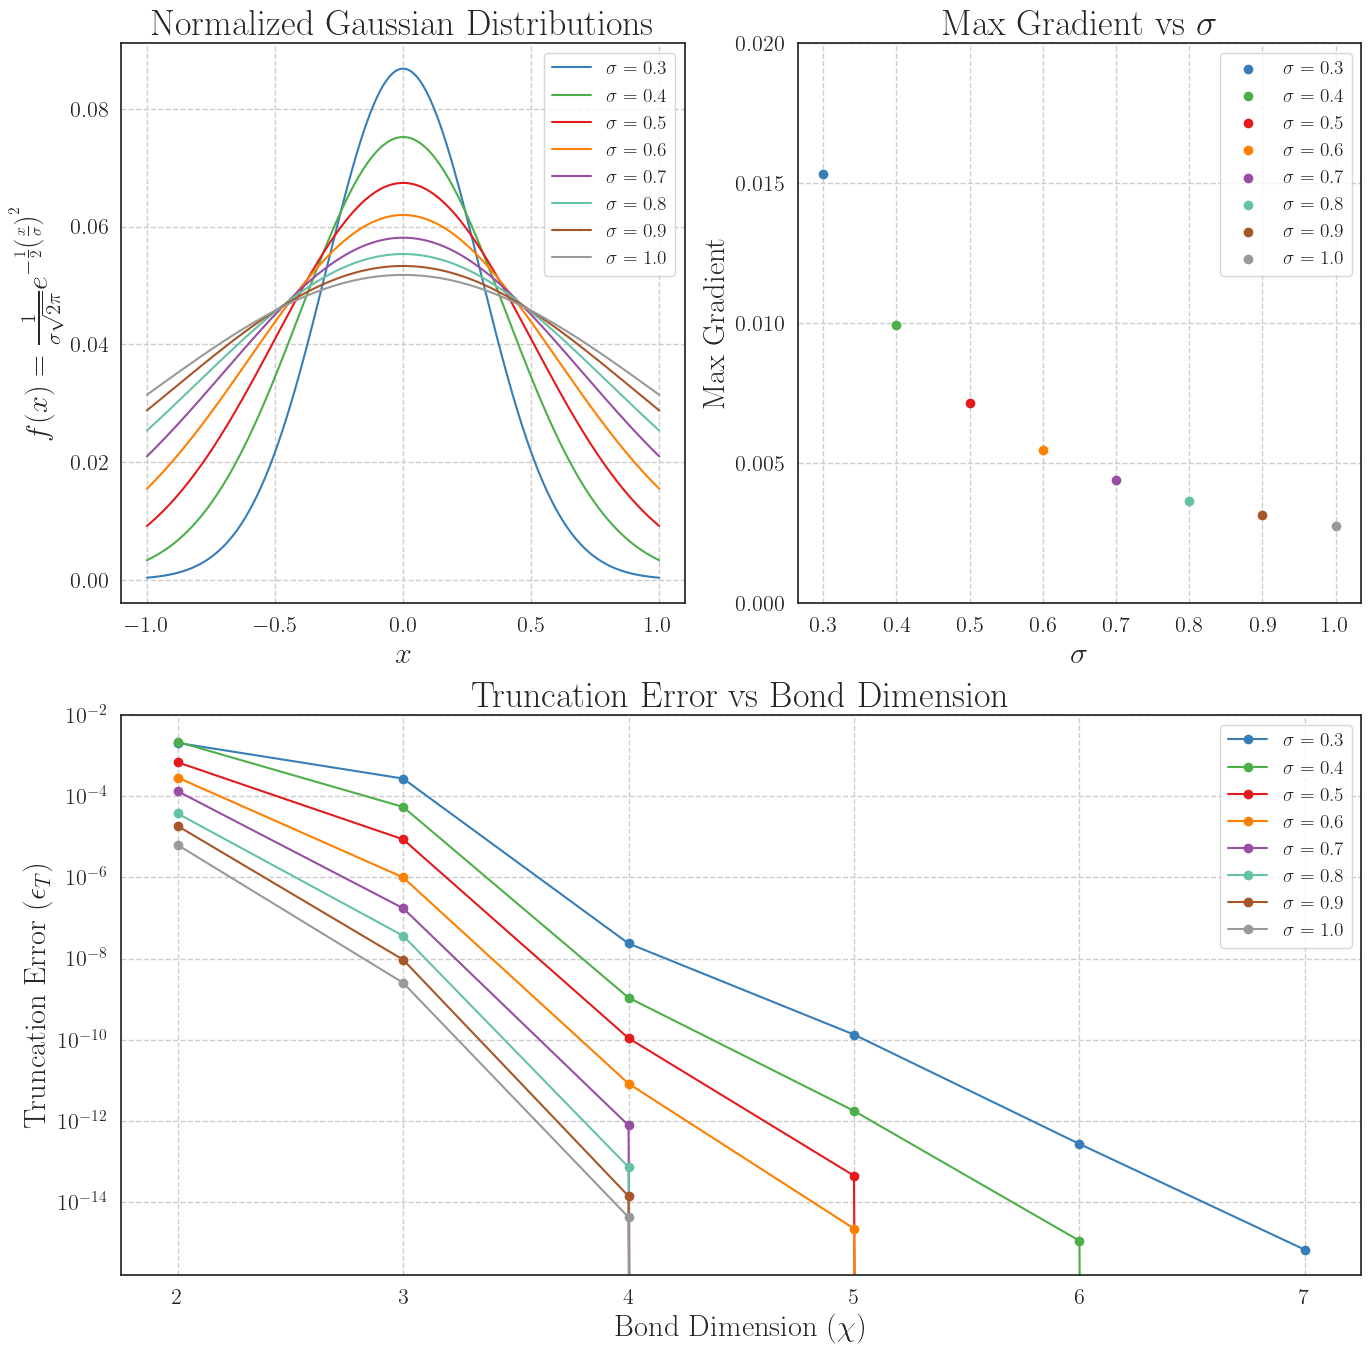

In [266]:
### DATA ('data') NEEDS TO BE RE-COMPUTED. It can essentially be done in the same manner as above. 

### When Gaussian data was collected, it was done in using similar albeit a less efficient manner.

### 'data' = a list of dictionaries. Each entry corresponds to a std value. Dictionaries take the form of key = specific bond dimension. value = best possible fidelity.


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator, NullFormatter, FuncFormatter
import matplotlib.gridspec as gridspec
from collections import OrderedDict
from matplotlib.colors import ListedColormap


filtered_max_gradients = [0.015316596805035942, 0.009950433848146645, 0.007135207911879604, 0.005465803141333936, 0.004393591857528634, 0.0036612572219425488, 0.003135287467557646, 0.002741607649956034]
bond_dimensions = [2, 3, 4, 5, 6, 7]

filtered_data = gausses_errors
# -------------------------------


# -------------------------------
# Configure LaTeX Fonts and Font Sizes
# -------------------------------
plt.rcParams.update({
    "text.usetex": True,          # Enable LaTeX rendering
    "font.family": "serif",       # Use serif fonts
    "axes.titlesize": 26,         # Title font size
    "axes.labelsize": 22,         # Axis label font size
    "xtick.labelsize": 16,        # X-axis tick label size
    "ytick.labelsize": 16,        # Y-axis tick label size
    "legend.fontsize": 14,        # Reduced legend font size
    "legend.title_fontsize": 16,  # Legend title font size
})

# -------------------------------
# Prepare Colors
# -------------------------------
custom_colors = [
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#e41a1c",  # Red
    "#ff7f00",  # Orange
    "#984ea3",  # Purple
    "#66c2a5",  # Teal
    "#a65628",  # Brown
    "#999999",  # Grey
    "#ffd92f",  # Light Yellow
]

cmap = ListedColormap(custom_colors)
colors = [cmap(i) for i in range(len(filtered_s_values))]

# -------------------------------
# Create the Subplots with GridSpec
# -------------------------------
fig = plt.figure(figsize=(16, 16))  # Updated figure size
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.2, wspace=0.2)

# Define subplot axes
ax_gaussian = fig.add_subplot(gs[0, 0])      # Top-left
ax_max_grad = fig.add_subplot(gs[0, 1])      # Top-right
ax_infidelity = fig.add_subplot(gs[1, :])    # Bottom spanning both columns

# -------------------------------
# Plot 1: Normalized Gaussian Distributions
# -------------------------------
x = np.linspace(-1, 1, 500)
for s, color in zip(filtered_s_values, colors):
    # Compute the normalized Gaussian
    y = (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-x**2 / (2 * s**2))
    y = y / np.linalg.norm(y)
    ax_gaussian.plot(x, y, color=color, label=rf'$\sigma={s}$')  # LaTeX-formatted label

ax_gaussian.set_title('Normalized Gaussian Distributions')
ax_gaussian.set_xlabel(r'$x$')
ax_gaussian.set_ylabel(r'$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x}{\sigma}\right)^2}$')
ax_gaussian.grid(True, ls="--")
ax_gaussian.legend(loc='upper right', fontsize=14, title_fontsize=16, frameon=True)

# -------------------------------
# Plot 2: Max Gradient vs s_value (Linear Scale)
# -------------------------------
for s, mg, color in zip(filtered_s_values, filtered_max_gradients, colors):
    ax_max_grad.scatter(s, mg, color=color, label=rf'$\sigma={s}$')  # LaTeX-formatted label

ax_max_grad.set_title(r'Max Gradient vs $\sigma$')
ax_max_grad.set_xlabel(r'$\sigma$')
ax_max_grad.set_ylabel('Max Gradient')
ax_max_grad.set_xticks(filtered_s_values)

# Remove LogLocator and FuncFormatter since we are using a linear scale
# ax_max_grad.set_yscale('log')  # Keep y-axis on linear scale
# ax_max_grad.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
# ax_max_grad.yaxis.set_major_formatter(FuncFormatter(lambda y, _: r'$10^{{{}}}$'.format(int(np.log10(y)))))
# ax_max_grad.yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels

# Optional: Set y-ticks manually if needed
# Determine reasonable y-ticks based on your data range
y_min, y_max = ax_max_grad.get_ylim()
yticks = np.linspace(0, 0.020, num=5)
ax_max_grad.set_yticks(yticks)

# Optionally format y-tick labels
# ax_max_grad.set_yticklabels([f'{y:.2e}' for y in yticks])

ax_max_grad.grid(True, which="both", ls="--")
ax_max_grad.legend(loc='upper right', fontsize=14, title_fontsize=16, frameon=True)

# -------------------------------
# Plot 3: Infidelity vs Bond Dimension (Log Scale)
# -------------------------------
for s, data_entry, color in zip(filtered_s_values, filtered_data, colors):
    # Extract fidelities for the specified bond dimensions
    fidelities = [data_entry.get(bond_dim, np.nan) for bond_dim in bond_dimensions]
    
    # Compute infidelities, ensuring they are positive for log scale
    infidelities = []
    for f in fidelities:
        if np.isnan(f) or f <= 0:
            infidelities.append(np.nan)
        else:
            inf = 1 - f
            if inf < 0.6e-15:
                inf = 0.0
            infidelities.append(inf)
    
    ax_infidelity.plot(bond_dimensions, infidelities, marker='o', color=color, label=rf'$\sigma={s}$')  # LaTeX-formatted label

ax_infidelity.set_title(r'Truncation Error vs Bond Dimension')
ax_infidelity.set_xlabel(r'Bond Dimension ($\chi$)')
ax_infidelity.set_ylabel(r'Truncation Error ($\epsilon_T$)')
ax_infidelity.set_xticks(bond_dimensions)
ax_infidelity.set_yscale('log')  # Set y-axis to log scale

# Set y-ticks to exact negative powers of 10 from 1e-2 to 1e-16
infidelity_ticks = [10**-i for i in range(2, 16, 2)]  # [1e-2, 1e-4, ..., 1e-14]
ax_infidelity.set_yticks(infidelity_ticks)
ax_infidelity.yaxis.set_major_formatter(FuncFormatter(lambda y, _: r'$10^{{{}}}$'.format(int(np.log10(y)))))
ax_infidelity.yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels
ax_infidelity.grid(True, which="both", ls="--")
ax_infidelity.legend(loc='upper right', fontsize=14, title_fontsize=16, frameon=True)

# -------------------------------
# Adjust Layout
# -------------------------------
plt.tight_layout()

# -------------------------------
# Save the Plot
# -------------------------------
plt.savefig(r"C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\gaussian_fig2", dpi=300, transparent=True)

# -------------------------------
# Display the Plots
# -------------------------------
plt.show()

### Visualising MPS Truncation

In [8]:
f = lambda x, mu=0, sigma=0.3: (1 / (sigma * (2 * 3.1416)**0.5)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [9]:
n = 12
#Exact MPS
f_values,x_values, f_tensor, MPS_cores_exact, MPS_exact, s_vals_exact = compute_MPS_of_function(f,n)

#Find Singular Value Threshold for Varying Bond Dimensions
thresholds = find_max_nth_elements(s_vals_exact, max_n=12)

Transition in Fidelity with Chi

In [10]:
state_vecs = []

for chi in [1,3,5]:
        t = thresholds[chi]
        coarse_truncated_s_vals = coarse_truncate_s_vals(s_vals_exact, threshold=t)
        coarse_truncated_ranks = ranks_from_s_vals(coarse_truncated_s_vals) 
        min_s_val = max(len(arr) for arr in coarse_truncated_s_vals)
        MPS_cores_trunc, s_vals_trunc = MatrixProductState.svd_decompose(f_tensor, truncate_ranks=coarse_truncated_ranks)

        #FIDELITY
        MPS_trunc = MatrixProductState(MPS_cores_trunc)
        MPS_trunc.right_normalize("F")
        y_mps_approx = MPS_trunc.get_all_amplitudes()
        state_vecs.append(y_mps_approx/np.linalg.norm(y_mps_approx))
        state_fid = state_fidelity(f_values, y_mps_approx)
        print(state_fid)

0.5306983099268129
0.9997257756238461
0.9999999998671365


c:\Users\0josh\miniconda3\envs\mps_env1\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


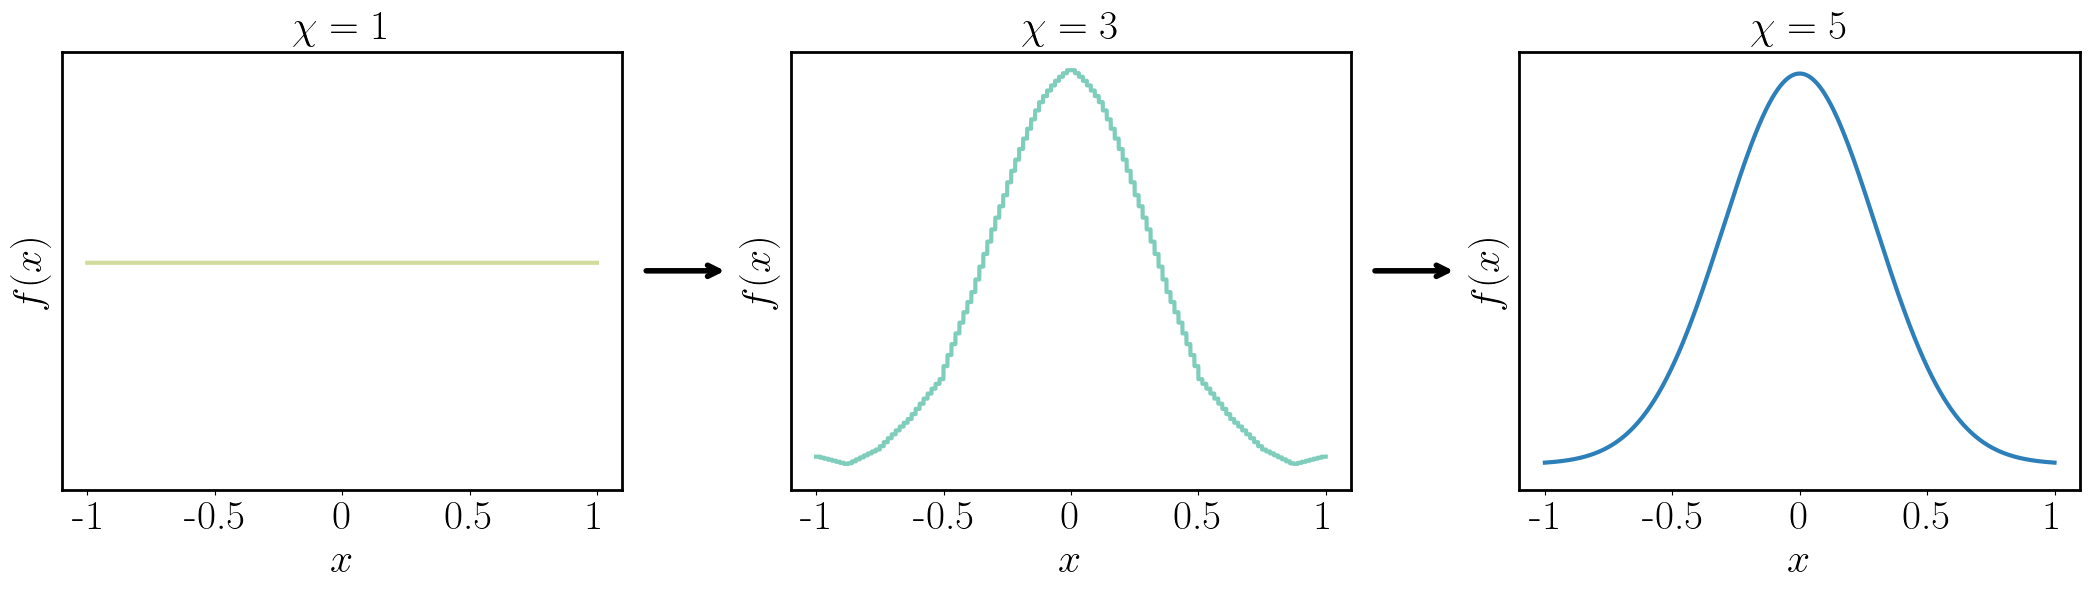

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline

# Configure Matplotlib to use LaTeX-style fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 30,
    "xtick.labelsize": 30,  # Remove x-axis tick labels
    "ytick.labelsize": 0,  # Remove y-axis tick labels
    "text.latex.preamble": [r"\usepackage{amsmath}",r"\usepackage{bm}"],
})

# Set parameters
num_points = 2**n
x = np.linspace(-1, 1, num_points)

y1 = state_vecs[0]
y2 = state_vecs[1]
y3 = state_vecs[2]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

xticks_positions = [-1, -0.5, 0, 0.5, 1]
xticks_labels = ['-1', '-0.5', '0', '0.5', '1']

# Plot 1: Smooth Sine Wave
axs[0].plot(x, y1, color='#d1db9c',linewidth=3)
axs[0].set_title(r'$\chi = 1$',fontsize=30,pad=10,weight='bold')  # Added Title
axs[0].set_xlabel('$x$',weight='bold')
axs[0].set_ylabel('$f(x)$',weight='bold')
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_yticks([])  # Remove y-axis ticks

# Plot 2: Smooth Random Fluctuations Between 0 and 12
axs[1].plot(x, y2, color='#7fcdbb',linewidth=3)
axs[1].set_title(r'$\chi = 3$',fontsize=30,pad=10,weight='bold')  # Added Title
axs[1].set_xlabel('$x$',weight='bold')
axs[1].set_ylabel('$f(x)$',weight='bold')
axs[1].set_ylim([0, 12])
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_yticks([])  # Remove y-axis ticks

# Plot 3: Smooth Spline Fit to Random Points
axs[2].plot(x, y3, color='#2c7fb8',linewidth=3)
axs[2].set_title(r'$\chi = 5$',fontsize=30,pad=10,weight='bold')  # Added Title
axs[2].set_xlabel('$x$',weight='bold')
axs[2].set_ylabel('$f(x)$',weight='bold')
axs[2].set_xticks([])  # Remove x-axis ticks
axs[2].set_yticks([])  # Remove y-axis ticks

axs[0].set_ylim([-0.002, 0.032])
axs[1].set_ylim([-0.002, 0.032])
axs[2].set_ylim([-0.002, 0.032])

axs[0].set_xticks(xticks_positions)
axs[1].set_xticks(xticks_positions)
axs[2].set_xticks(xticks_positions)

axs[0].set_xticklabels(xticks_labels)
axs[1].set_xticklabels(xticks_labels)
axs[2].set_xticklabels(xticks_labels)

def set_spine_thickness(ax, linewidth=3):
    for spine in ax.spines.values():
        spine.set_linewidth(linewidth)

for ax in axs:
    set_spine_thickness(ax, linewidth=2)

# Adjust layout for better spacing
plt.tight_layout()

# Increase horizontal space to make room for arrows
fig.subplots_adjust(wspace=0.3)

# Function to add an arrow between two axes with padding
def add_arrow(ax1, ax2, fig, text=None, text_pos=(0, 0.05), delta=0.01,shift=0.0):
    # Get the bounding boxes of the axes in figure coordinates
    bbox1 = ax1.get_position()
    bbox2 = ax2.get_position()

    # Calculate start and end points for the arrow with padding
    start_x = bbox1.x1 - delta + shift # Slightly inside the first subplot
    start_y = bbox1.y0 + bbox1.height / 2
    end_x = bbox2.x0 + delta + shift    # Slightly inside the second subplot
    end_y = bbox2.y0 + bbox2.height / 2

    # Create the arrow
    arrow = FancyArrowPatch(
        (start_x, start_y),
        (end_x, end_y),
        transform=fig.transFigure,
        arrowstyle="->",
        color='black',
        mutation_scale=20,
        linewidth=4
    )
    fig.patches.append(arrow)

    # Add text if provided
    if text:
        fig.text(
            (start_x + end_x) / 2 + text_pos[0]*0.02,
            (start_y + end_y) / 2 + text_pos[1]*0.02,
            text,
            ha='center',
            va='center',
            fontsize=12,
            backgroundcolor='white'
        )

# Add arrows between Plot 1 to Plot 2 and Plot 2 to Plot 3 with padding
add_arrow(axs[0], axs[1], fig, text_pos=(0, 0.05), delta=-0.02,shift=-0.01)
add_arrow(axs[1], axs[2], fig, text_pos=(0, 0.05), delta=-0.02, shift=-0.01)

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\bond_dimension_transition.png', dpi=600, bbox_inches='tight',transparent=False)

# Display the plots
plt.show()


### Scalability Analysis

In [20]:
gaussian_func = lambda x, mu=0, sigma=0.3: (1 / (sigma * (2 * 3.1416)**0.5)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [21]:
gaussian_func = [gaussian_func]

gaussian_data = []

n_vals = [8,12,16,20,24]

for m in n_vals:
    trunc_data = get_bond_data(gaussian_func,n=m)
    trunc_data = trunc_data[0]
    gaussian_data.append(trunc_data)

<function <lambda> at 0x0000025DBFD80708>
bond = 1 and fidelity = 0.5287936563266381
bond = 2 and fidelity = 0.9979560904937697
bond = 3 and fidelity = 0.9997519879502236
bond = 4 and fidelity = 0.9999999867246274
bond = 5 and fidelity = 0.9999999998963942
bond = 6 and fidelity = 0.9999999999997018
bond = 7 and fidelity = 1.0000000000000018
bond = 8 and fidelity = 1.0000000000000027
[{1: 0.5287936563266381, 2: 0.9979560904937697, 3: 0.9997519879502236, 4: 0.9999999867246274, 5: 0.9999999998963942, 6: 0.9999999999997018, 7: 1.0000000000000018, 8: 1.0000000000000027}]
<function <lambda> at 0x0000025DBFD80708>
bond = 1 and fidelity = 0.5306983099268129
bond = 2 and fidelity = 0.9979252574651499
bond = 3 and fidelity = 0.9997257756238461
bond = 4 and fidelity = 0.9999999815731323
bond = 5 and fidelity = 0.9999999998671365
bond = 6 and fidelity = 0.9999999999998037
bond = 7 and fidelity = 0.9999999999999964
bond = 8 and fidelity = 1.0
[{1: 0.5306983099268129, 2: 0.9979252574651499, 3: 0.999

In [22]:
cheby_poly, knots = generate_piecewise_chebyshev((-1,1), num_subintervals=10, degree=4, seed=None)

In [23]:
cheby_func = [cheby_poly]

cheby_data = []

n_vals = [8,12,16,20,24]

for m in n_vals:
    trunc_data = get_bond_data(cheby_func,n=m)
    trunc_data = trunc_data[0]
    cheby_data.append(trunc_data)

<function generate_piecewise_chebyshev.<locals>.func at 0x0000025DBFD80288>
bond = 1 and fidelity = 0.534815177537329
bond = 2 and fidelity = 0.8840202029140378
bond = 3 and fidelity = 0.9258565287781031
bond = 4 and fidelity = 0.9657917318866186
bond = 5 and fidelity = 0.9893343417857843
bond = 6 and fidelity = 0.9957575871472408
bond = 7 and fidelity = 0.9985432796935358
bond = 8 and fidelity = 0.9998775336043606
[{1: 0.534815177537329, 2: 0.8840202029140378, 3: 0.9258565287781031, 4: 0.9657917318866186, 5: 0.9893343417857843, 6: 0.9957575871472408, 7: 0.9985432796935358, 8: 0.9998775336043606}]
<function generate_piecewise_chebyshev.<locals>.func at 0x0000025DBFD80288>
bond = 1 and fidelity = 0.5359350038676047
bond = 2 and fidelity = 0.8826668480071039
bond = 3 and fidelity = 0.9314101025486085
bond = 4 and fidelity = 0.9668677152492093
bond = 5 and fidelity = 0.9892339275833372
bond = 6 and fidelity = 0.9966769904031376
bond = 7 and fidelity = 0.9985936413021878
bond = 8 and fidel

In [24]:
print(gaussian_data)

[{1: 0.5287936563266381, 2: 0.9979560904937697, 3: 0.9997519879502236, 4: 0.9999999867246274, 5: 0.9999999998963942, 6: 0.9999999999997018, 7: 1.0000000000000018, 8: 1.0000000000000027}, {1: 0.5306983099268129, 2: 0.9979252574651499, 3: 0.9997257756238461, 4: 0.9999999815731323, 5: 0.9999999998671365, 6: 0.9999999999998037, 7: 0.9999999999999964, 8: 1.0}, {1: 0.5308173148397022, 2: 0.9979249975372939, 3: 0.9997257996424694, 4: 0.9999999751092131, 5: 0.9999999998658136, 6: 0.999999999999726, 7: 0.9999999999999971, 8: 0.9999999999999973}, {1: 0.5308247525069185, 2: 0.9979249877529573, 3: 0.9997258075858899, 4: 0.9999999746817131, 5: 0.9999999998405609, 6: 0.999999999999724, 7: 0.9999999999999984, 8: 1.0000000000000009}, {1: 0.5308252173605773, 2: 0.997924987166661, 3: 0.9997258081075102, 4: 0.9999999746801639, 5: 0.9999999998388855, 6: 0.9999999999996283, 7: 1.000000000000004, 8: 1.0000000000000027}]


In [3]:
n_vals = [8,12,16,20,24]

gaussian_data=[{1: 0.5287936563266381, 2: 0.9979560904937697, 3: 0.9997519879502236, 4: 0.9999999867246274, 5: 0.9999999998963942, 6: 0.9999999999997018, 7: 1.00000000000000}, {1: 0.5306983099268129, 2: 0.9979252574651499, 3: 0.9997257756238461, 4: 0.9999999815731323, 5: 0.9999999998671365, 6: 0.9999999999998037, 7: 1.0}, {1: 0.5308173148397022, 2: 0.9979249975372939, 3: 0.9997257996424694, 4: 0.9999999751092131, 5: 0.9999999998658136, 6: 0.999999999999726, 7: 1.0}, {1: 0.5308247525069185, 2: 0.9979249877529573, 3: 0.9997258075858899, 4: 0.9999999746817131, 5: 0.9999999998405609, 6: 0.999999999999724, 7: 1.0}, {1: 0.5308252173605773, 2: 0.997924987166661, 3: 0.9997258081075102, 4: 0.9999999746801639, 5: 0.9999999998388855, 6: 0.9999999999996283, 7: 1.00000000000000}]


In [4]:
cheby_104_data = [{1: 0.534815177537329, 2: 0.8840202029140378, 3: 0.9258565287781031, 4: 0.9657917318866186, 5: 0.9893343417857843, 6: 0.9957575871472408, 7: 0.9985432796935358, 8: 0.9998775336043606}, {1: 0.5359350038676047, 2: 0.8826668480071039, 3: 0.9314101025486085, 4: 0.9668677152492093, 5: 0.9892339275833372, 6: 0.9966769904031376, 7: 0.9985936413021878, 8: 0.9998384379297806}, {1: 0.5359594178419874, 2: 0.8825735384894235, 3: 0.9317365830341552, 4: 0.966998641974615, 5: 0.9893133926587145, 6: 0.9967025506311512, 7: 0.9985936787719645, 8: 0.9998334925320566}, {1: 0.5359607653473817, 2: 0.8825676544978492, 3: 0.9317565421739992, 4: 0.9670070057892856, 5: 0.9893186064858159, 6: 0.9967044825290459, 7: 0.9985940486667042, 8: 0.9998336157163361}, {1: 0.5359608488701672, 2: 0.882567286542371, 3: 0.9317577879033354, 4: 0.9670075292205361, 5: 0.9893189332978384, 6: 0.9967046045642634, 7: 0.9985940732063576, 8: 0.9998336250853687}]


In [25]:
print(cheby_data)

[{1: 0.534815177537329, 2: 0.8840202029140378, 3: 0.9258565287781031, 4: 0.9657917318866186, 5: 0.9893343417857843, 6: 0.9957575871472408, 7: 0.9985432796935358, 8: 0.9998775336043606}, {1: 0.5359350038676047, 2: 0.8826668480071039, 3: 0.9314101025486085, 4: 0.9668677152492093, 5: 0.9892339275833372, 6: 0.9966769904031376, 7: 0.9985936413021878, 8: 0.9998384379297806}, {1: 0.5359594178419874, 2: 0.8825735384894235, 3: 0.9317365830341552, 4: 0.966998641974615, 5: 0.9893133926587145, 6: 0.9967025506311512, 7: 0.9985936787719645, 8: 0.9998334925320566}, {1: 0.5359607653473817, 2: 0.8825676544978492, 3: 0.9317565421739992, 4: 0.9670070057892856, 5: 0.9893186064858159, 6: 0.9967044825290459, 7: 0.9985940486667042, 8: 0.9998336157163361}, {1: 0.5359608488701672, 2: 0.882567286542371, 3: 0.9317577879033354, 4: 0.9670075292205361, 5: 0.9893189332978384, 6: 0.9967046045642634, 7: 0.9985940732063576, 8: 0.9998336250853687}]


All infidelity values are positive.


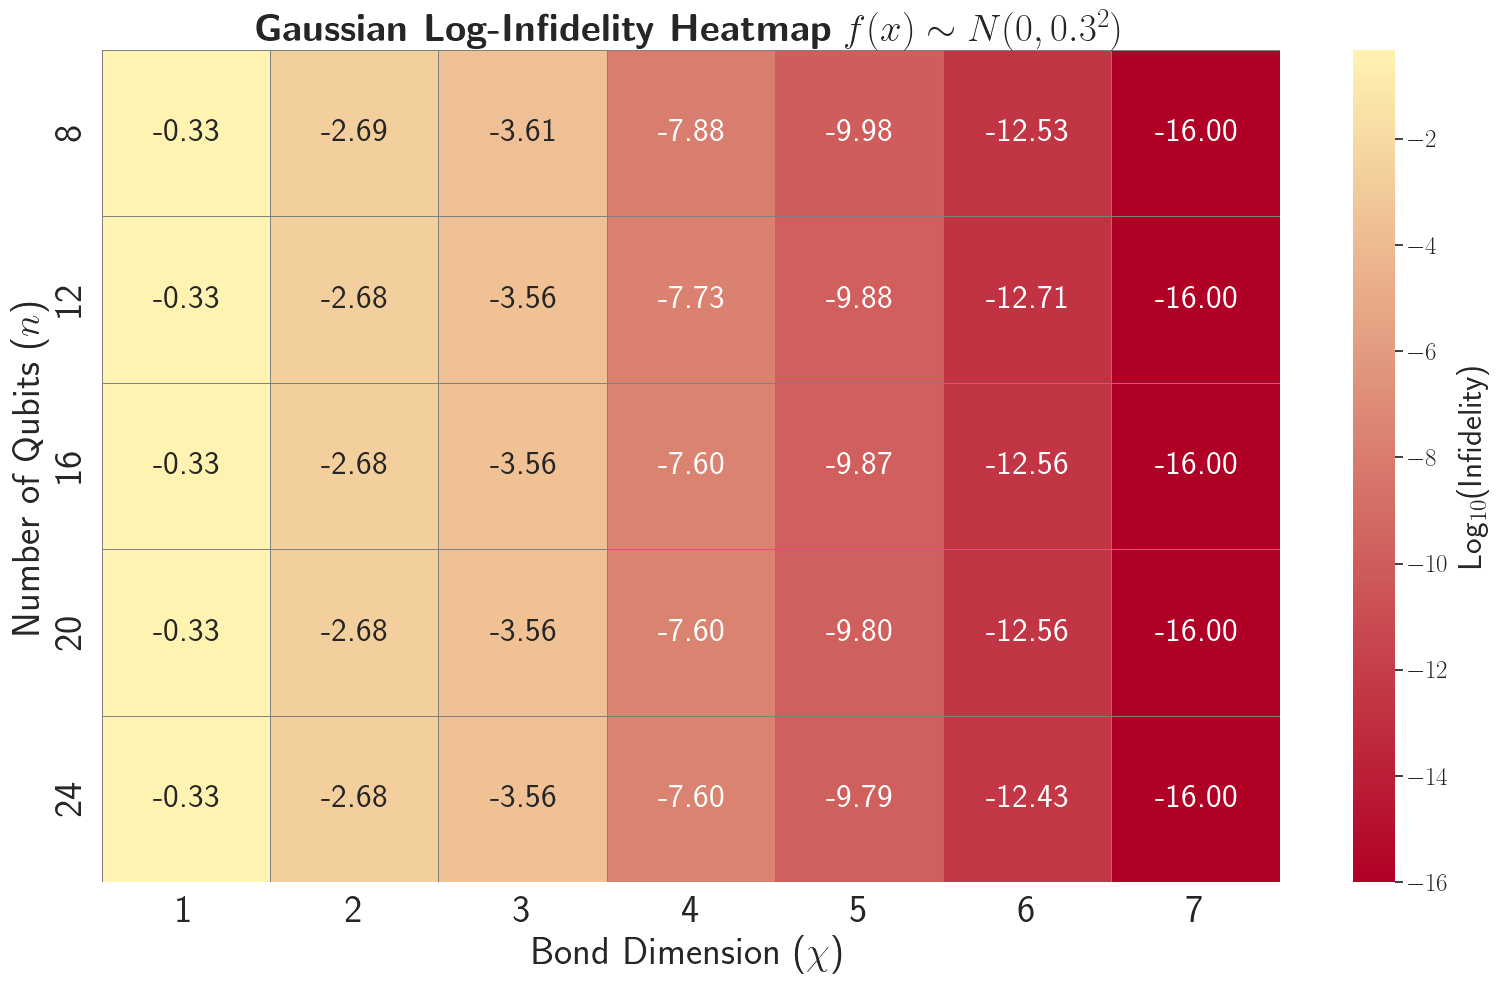

In [38]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

data_records = []
epsilon = 1e-16  # Set epsilon to 1e-16 as per your request

n_vals = [8,12,16,20,24]


for data, n in zip(gaussian_data, n_vals):
    for bond_dim, fidelity in data.items():
        infidelity = 1 - fidelity
        # Replace non-positive infidelities with epsilon
        infidelity = infidelity if infidelity > 0 else epsilon
        data_records.append({'n_val': n, 'bond_dim': bond_dim, 'infidelity': infidelity})

df = pd.DataFrame(data_records)

# Verify that all infidelity values are positive
non_positive = df[df['infidelity'] <= 0]
if not non_positive.empty:
    print("Non-positive infidelity values found and replaced with epsilon:")
    print(non_positive)
    df['infidelity'] = df['infidelity'].apply(lambda x: x if x > 0 else epsilon)
else:
    print("All infidelity values are positive.")

# Apply log10 transformation to infidelity
df['log_infidelity'] = np.log10(df['infidelity'])

# ================================
# Step 2: Create a Custom Colormap
# ================================

# Create a custom colormap transitioning from red to blue
# You can adjust the number of colors or specific shades as needed
custom_cmap = LinearSegmentedColormap.from_list('RedBlue', ['#B10026', '#FFF3B2'], N=256)
#custom_cmap = 'Wistia'
# ================================
# Step 3: Configure Matplotlib for LaTeX Fonts
# ================================

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 28,
        "axes.titlesize": 28,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
        "legend.fontsize": 22,
        "legend.title_fontsize": 22,
    })
# ================================
# Step 4: Pivot the DataFrame for Heatmap
# ================================

# Pivot the DataFrame to have n_val as rows and bond_dim as columns
heatmap_data = df.pivot(index='n_val', columns='bond_dim', values='log_infidelity')

# Sort the DataFrame for better visualization (optional)
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# ================================
# Step 5: Create the Heatmap
# ================================

# Set the style for seaborn
sns.set(style="white")

# Initialize the matplotlib figure
plt.figure(figsize=(16, 10))

# Create the heatmap
heatmap = sns.heatmap(
    heatmap_data,
    annot=True,                  # Annotate cells with data
    fmt=".2f",                   # Format annotations to two decimal places
    cmap=custom_cmap,            # Use the custom red-blue colormap
    cbar_kws={'label': r'$log_{10}$(Infidelity)'},  # Colorbar label with LaTeX
    linewidths=0.5,              # Line width between cells
    linecolor='gray',            # Line color between cells
    annot_kws={'size':24}
)

# ================================
# Step 6: Customize Axis Labels and Title
# ================================

# Set axis labels with LaTeX and font size 22
plt.xlabel(r'Bond Dimension ($\chi$)', fontsize=28)
plt.ylabel(r'Number of Qubits ($n$)', fontsize=28)

# Set the title with LaTeX and font size 22
plt.title(r'\textbf{Gaussian Log-Infidelity Heatmap} $f(x)\sim N(0,0.3^2)$', fontsize=28)

# ================================
# Step 7: Customize Tick Labels
# ================================

# Set tick labels font size to 18
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel(r'Log$_{10}$(Infidelity)', fontsize=24)
cbar.ax.tick_params(labelsize=18)



# Optional: Reverse the y-axis to have higher n_val at the top
#plt.gca().invert_yaxis()

# ================================
# Step 8: Adjust Layout and Display
# ================================

plt.tight_layout()  # Adjust the padding between and around subplots

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\gaussian_scaling.png', dpi=600,transparent=True)

# Display the heatmap
plt.show()

All infidelity values are positive.


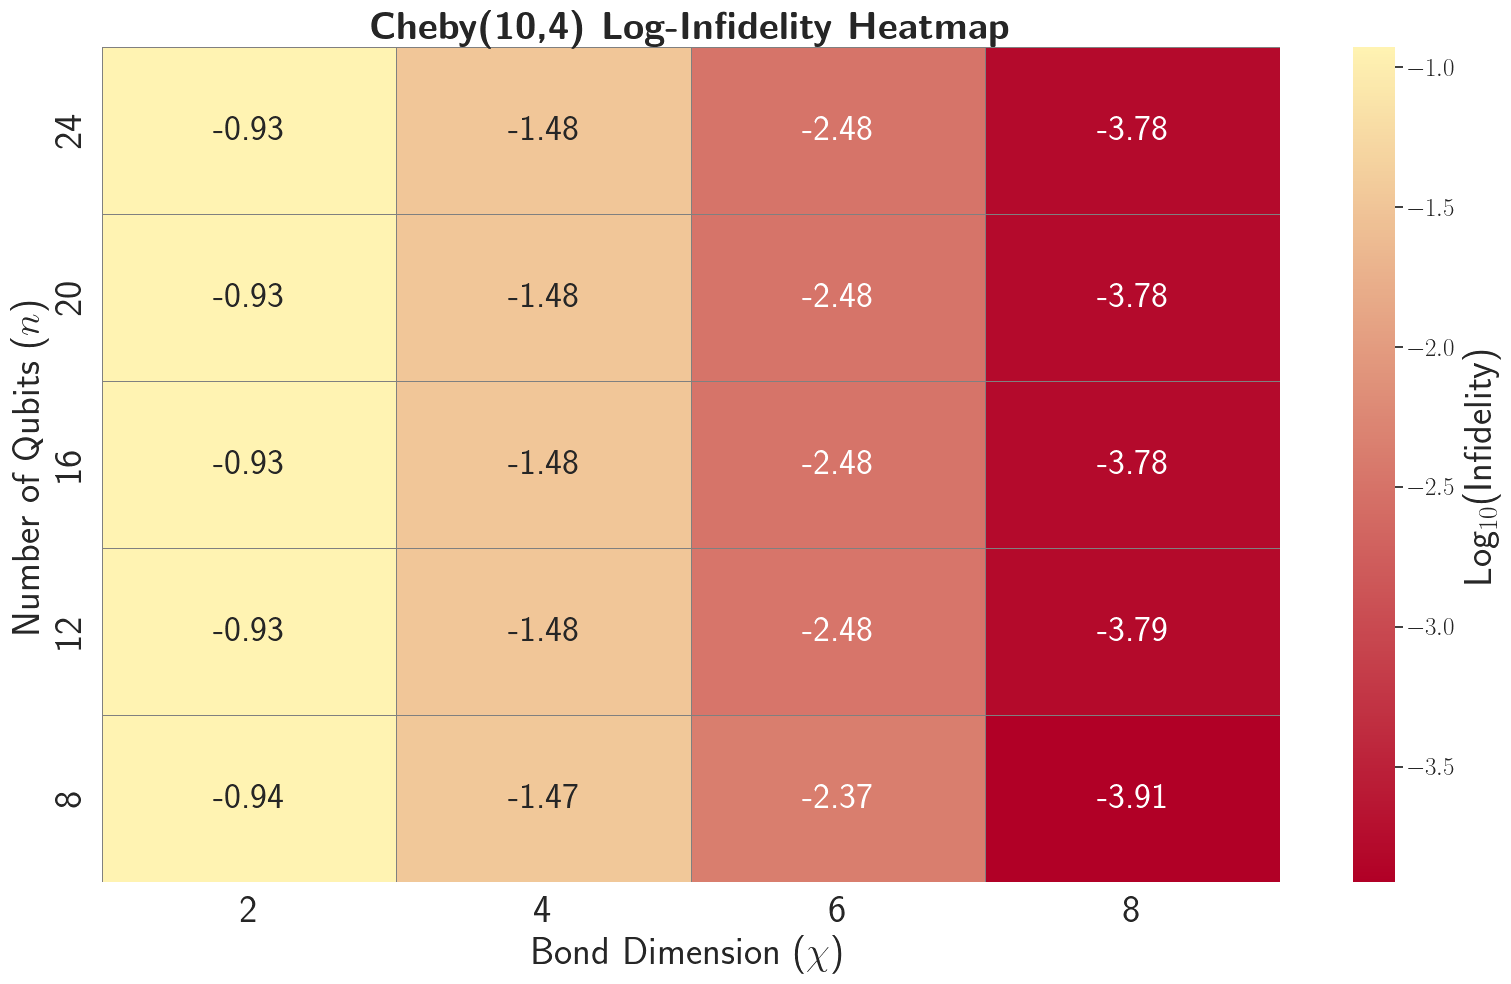

In [17]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

data_records = []
epsilon = 1e-16  # Set epsilon to 1e-16 as per your request

n_vals = [8,12,16,20,24]


for data, n in zip(cheby_104_data, n_vals):
    for bond_dim, fidelity in data.items():
        infidelity = 1 - fidelity
        # Replace non-positive infidelities with epsilon
        infidelity = infidelity if infidelity > 0 else epsilon
        data_records.append({'n_val': n, 'bond_dim': bond_dim, 'infidelity': infidelity})

df = pd.DataFrame(data_records)

# Verify that all infidelity values are positive
non_positive = df[df['infidelity'] <= 0]
if not non_positive.empty:
    print("Non-positive infidelity values found and replaced with epsilon:")
    print(non_positive)
    df['infidelity'] = df['infidelity'].apply(lambda x: x if x > 0 else epsilon)
else:
    print("All infidelity values are positive.")

# Apply log10 transformation to infidelity
df['log_infidelity'] = np.log10(df['infidelity'])

# ================================
# Step 2: Create a Custom Colormap
# ================================

# Create a custom colormap transitioning from red to blue
# You can adjust the number of colors or specific shades as needed
custom_cmap = LinearSegmentedColormap.from_list('RedBlue', ['#B10026', '#FFF3B2'], N=256)
#custom_cmap = 'Wistia'
# ================================
# Step 3: Configure Matplotlib for LaTeX Fonts
# ================================

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": 28,
        "axes.titlesize": 28,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
        "legend.fontsize": 22,
        "legend.title_fontsize": 22,
    })
# Step 4: Pivot the DataFrame for Heatmap
# ================================
plt.rcParams.update({
    "text.usetex": True,                         # Enable LaTeX rendering
    "font.family": "serif",                      # Use a standard LaTeX serif font
    "font.serif": ["Computer Modern Roman"],     # Use LaTeX's default font (Computer Modern)
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}",  # Add LaTeX packages if needed
    "axes.labelsize": 28,
    "axes.titlesize": 28,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 22,
    "legend.title_fontsize": 22,
})


# Pivot the DataFrame to have n_val as rows and bond_dim as columns
heatmap_data = df.pivot(index='n_val', columns='bond_dim', values='log_infidelity')

# Sort the DataFrame for better visualization (optional)
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

df_filtered = df[df['bond_dim'] % 2 == 0]
heatmap_data_filtered = df_filtered.pivot(index='n_val', columns='bond_dim', values='log_infidelity')

# Sort the DataFrame for better visualization (optional)
heatmap_data_filtered = heatmap_data_filtered.sort_index().sort_index(axis=1)

# ================================
# Step 5: Create the Heatmap
# ================================

# Set the style for seaborn
sns.set(style="white")

# Initialize the matplotlib figure
plt.figure(figsize=(16, 10))

heatmap = sns.heatmap(
    heatmap_data_filtered,
    annot=True,                  # Annotate cells with data
    fmt=".2f",                   # Format annotations to two decimal places
    cmap=custom_cmap,            # Use the custom red-blue colormap
    cbar_kws={'label': r'$log_{10}$(Infidelity)'},  # Colorbar label with LaTeX
    linewidths=0.5,              # Line width between cells
    linecolor='gray',            # Line color between cells
    annot_kws={'size':26}
)

# Reverse the y-axis to have higher 'n_val' at the top
plt.gca().invert_yaxis()

# ================================
# Step 6: Customize Axis Labels and Title
# ================================

# Set axis labels with LaTeX and font size 22
plt.xlabel(r'Bond Dimension ($\chi$)', fontsize=28)
plt.ylabel(r'Number of Qubits ($n$)', fontsize=28)

# Set the title with LaTeX and font size 22
plt.title(r'\textbf{Cheby(10,4) Log-Infidelity Heatmap}', fontsize=28)

# ================================
# Step 7: Customize Tick Labels
# ================================

# Set tick labels font size to 18
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel(r'Log$_{10}$(Infidelity)', fontsize=28)
cbar.ax.tick_params(labelsize=18)



# Optional: Reverse the y-axis to have higher n_val at the top
#plt.gca().invert_yaxis()

# ================================
# Step 8: Adjust Layout and Display
# ================================

plt.tight_layout()  # Adjust the padding between and around subplots

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\cheby104_scaling.pdf', dpi=600,transparent=False)

# Display the heatmap
plt.show()

In [23]:
root_func = lambda x: np.sqrt(x+1)

In [24]:
root_func = [root_func]

gaussian_data = []

n_vals = [8,12,16,20,24]

for m in n_vals:
    trunc_data = get_bond_data(root_func,n=m)
    trunc_data = trunc_data[0]
    gaussian_data.append(trunc_data)

<function <lambda> at 0x000001991F04DD38>
bond = 1 and fidelity = 0.9874388069692652
bond = 2 and fidelity = 0.9999682995093081
bond = 3 and fidelity = 0.9999999718374066
bond = 4 and fidelity = 0.9999999999915814
bond = 5 and fidelity = 0.9999999999999996
bond = 6 and fidelity = 1.0
bond = 7 and fidelity = 1.0
bond = 8 and fidelity = 1.0000000000000009
[{1: 0.9874388069692652, 2: 0.9999682995093081, 3: 0.9999999718374066, 4: 0.9999999999915814, 5: 0.9999999999999996, 6: 1.0, 7: 1.0, 8: 1.0000000000000009}]
<function <lambda> at 0x000001991F04DD38>
bond = 1 and fidelity = 0.9879975166737673
bond = 2 and fidelity = 0.9999759748458549
bond = 3 and fidelity = 0.9999999727791244
bond = 4 and fidelity = 0.9999999999875628
bond = 5 and fidelity = 0.9999999999999982
bond = 6 and fidelity = 1.0000000000000022
bond = 7 and fidelity = 1.0000000000000027
bond = 8 and fidelity = 0.9999999999999982
[{1: 0.9879975166737673, 2: 0.9999759748458549, 3: 0.9999999727791244, 4: 0.9999999999875628, 5: 0.99

In [29]:
root_func_data =   [
    {1: 0.9874388069692652, 2: 0.9999682995093081, 3: 0.9999999718374066, 4: 0.9999999999915814, 5: 0.9999999999999996, 6: 1.0},
    {1: 0.9879975166737673, 2: 0.9999759748458549, 3: 0.9999999727791244, 4: 0.9999999999875628, 5: 0.9999999999999982, 6: 1.0000000000000022},
    {1: 0.9880292490003294, 2: 0.9999768690269376, 3: 0.9999999726039628, 4: 0.9999999999880038, 5: 0.9999999999999982, 6: 1.0000000000000009},
    {1: 0.9880311793770219, 2: 0.9999769191183533, 3: 0.9999999738476433, 4: 0.9999999999859717, 5: 0.9999999999999996, 6: 1.0},
    {1: 0.9880312991871367, 2: 0.9999769221247639, 3: 0.9999999739180101, 4: 0.9999999999868288, 5: 0.9999999999999929, 6: 1.0}
]

All infidelity values are positive.


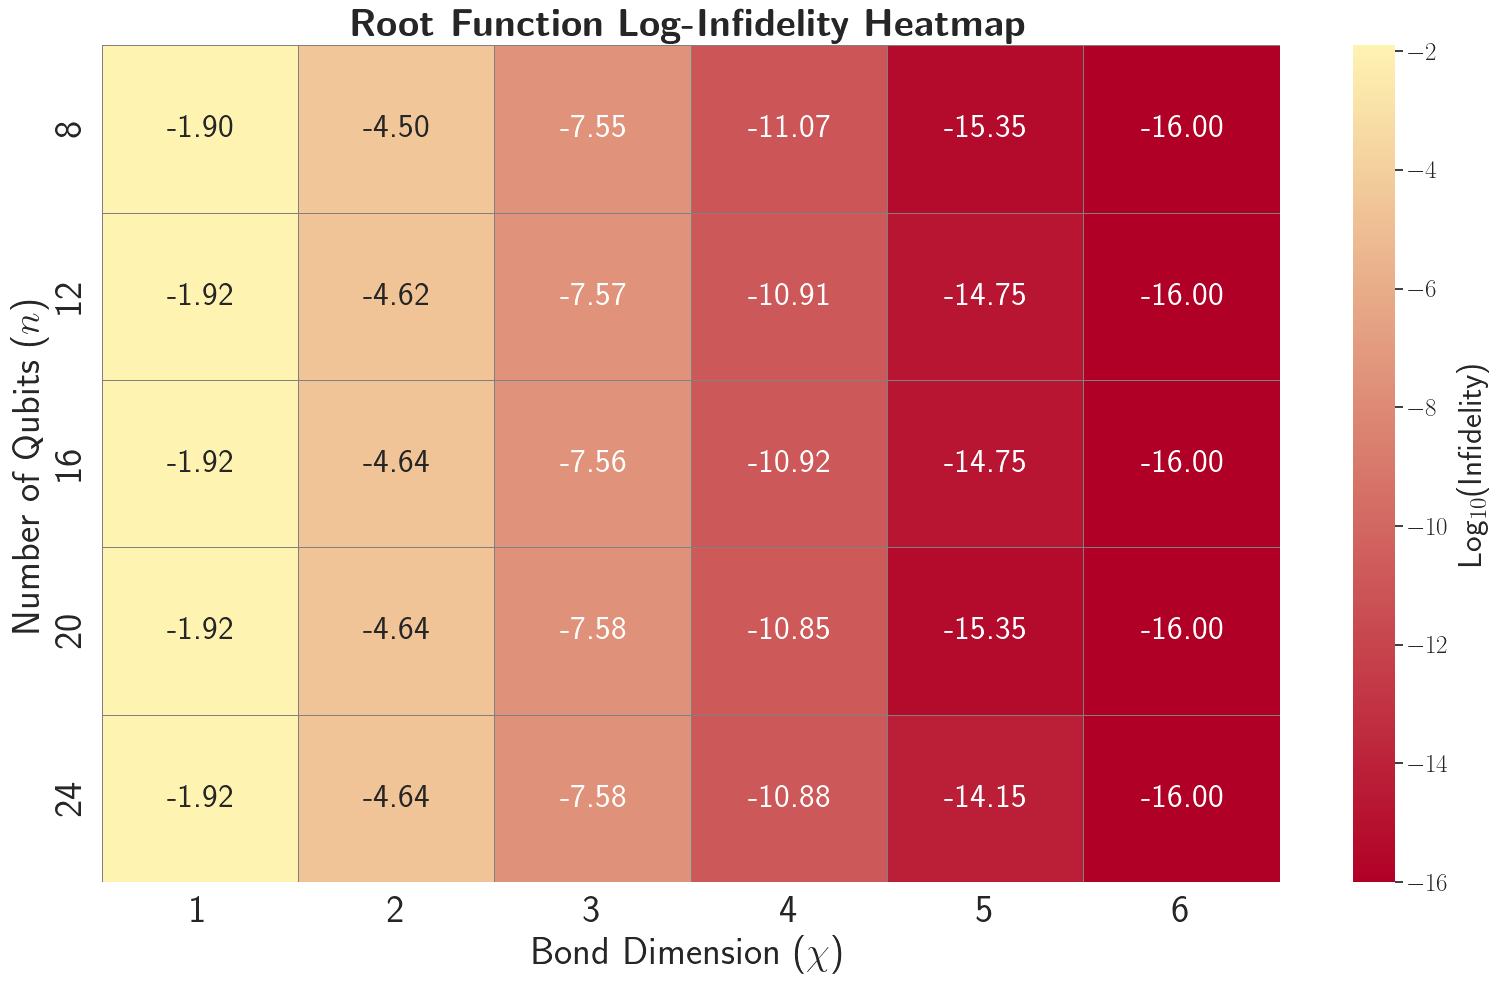

In [37]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

data_records = []
epsilon = 1e-16  # Set epsilon to 1e-16 as per your request

n_vals = [8,12,16,20,24]


for data, n in zip(root_func_data, n_vals):
    for bond_dim, fidelity in data.items():
        infidelity = 1 - fidelity
        # Replace non-positive infidelities with epsilon
        infidelity = infidelity if infidelity > 0 else epsilon
        data_records.append({'n_val': n, 'bond_dim': bond_dim, 'infidelity': infidelity})

df = pd.DataFrame(data_records)

# Verify that all infidelity values are positive
non_positive = df[df['infidelity'] <= 0]
if not non_positive.empty:
    print("Non-positive infidelity values found and replaced with epsilon:")
    print(non_positive)
    df['infidelity'] = df['infidelity'].apply(lambda x: x if x > 0 else epsilon)
else:
    print("All infidelity values are positive.")

# Apply log10 transformation to infidelity
df['log_infidelity'] = np.log10(df['infidelity'])

# ================================
# Step 2: Create a Custom Colormap
# ================================

# Create a custom colormap transitioning from red to blue
# You can adjust the number of colors or specific shades as needed
custom_cmap = LinearSegmentedColormap.from_list('RedBlue', ['#B10026', '#FFF3B2'], N=256)
#custom_cmap = 'Wistia'
# ================================
# Step 3: Configure Matplotlib for LaTeX Fonts
# ================================

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 28,
        "axes.titlesize": 28,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
        "legend.fontsize": 22,
        "legend.title_fontsize": 22,
    })
# ================================
# Step 4: Pivot the DataFrame for Heatmap
# ================================

# Pivot the DataFrame to have n_val as rows and bond_dim as columns
heatmap_data = df.pivot(index='n_val', columns='bond_dim', values='log_infidelity')

# Sort the DataFrame for better visualization (optional)
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# ================================
# Step 5: Create the Heatmap
# ================================

# Set the style for seaborn
sns.set(style="white")

# Initialize the matplotlib figure
plt.figure(figsize=(16, 10))

# Create the heatmap
heatmap = sns.heatmap(
    heatmap_data,
    annot=True,                  # Annotate cells with data
    fmt=".2f",                   # Format annotations to two decimal places
    cmap=custom_cmap,            # Use the custom red-blue colormap
    cbar_kws={'label': r'$log_{10}$(Infidelity)'},  # Colorbar label with LaTeX
    linewidths=0.5,              # Line width between cells
    linecolor='gray',            # Line color between cells
    annot_kws={'size':24}
)

# ================================
# Step 6: Customize Axis Labels and Title
# ================================

# Set axis labels with LaTeX and font size 22
plt.xlabel(r'Bond Dimension ($\chi$)', fontsize=28)
plt.ylabel(r'Number of Qubits ($n$)', fontsize=28)

# Set the title with LaTeX and font size 22
plt.title(r'\textbf{Root Function Log-Infidelity Heatmap}', fontsize=28)

# ================================
# Step 7: Customize Tick Labels
# ================================

# Set tick labels font size to 18
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel(r'Log$_{10}$(Infidelity)', fontsize=24)
cbar.ax.tick_params(labelsize=18)



# Optional: Reverse the y-axis to have higher n_val at the top
#plt.gca().invert_yaxis()

# ================================
# Step 8: Adjust Layout and Display
# ================================

plt.tight_layout()  # Adjust the padding between and around subplots

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\root_func_scaling.png', dpi=600,transparent=True)

# Display the heatmap
plt.show()

In [292]:
cheby_poly20 = generate_piecewise_chebyshev((-1,1), num_subintervals=20, degree=20, seed=42)

cheby_func20 = [cheby_poly20]

cheby_data20 = []

n_vals = [8,12,16,20,24]

for m in n_vals:
    trunc_data = get_bond_data(cheby_func20,n=m)
    trunc_data = trunc_data[0]
    cheby_data20.append(trunc_data)

<function generate_piecewise_chebyshev.<locals>.func at 0x0000025DC52E35E8>
bond = 1 and fidelity = 0.7117253494252702
bond = 2 and fidelity = 0.9224461863426495
bond = 3 and fidelity = 0.940383637725107
bond = 4 and fidelity = 0.954413697609008
bond = 5 and fidelity = 0.9709380277783402
bond = 6 and fidelity = 0.9800027827906801
bond = 7 and fidelity = 0.9879288602417963
bond = 8 and fidelity = 0.993905677835349
[{1: 0.7117253494252702, 2: 0.9224461863426495, 3: 0.940383637725107, 4: 0.954413697609008, 5: 0.9709380277783402, 6: 0.9800027827906801, 7: 0.9879288602417963, 8: 0.993905677835349}]
<function generate_piecewise_chebyshev.<locals>.func at 0x0000025DC52E35E8>
bond = 1 and fidelity = 0.7044459917391487
bond = 2 and fidelity = 0.9141482730496084
bond = 3 and fidelity = 0.933792855632453
bond = 4 and fidelity = 0.9503238246110132
bond = 5 and fidelity = 0.963862435497613
bond = 6 and fidelity = 0.9700956365319077
bond = 7 and fidelity = 0.9750395596346478
bond = 8 and fidelity = 

In [22]:
cheby20_data = [
    {1: 0.7117253494252702, 2: 0.9224461863426495, 3: 0.940383637725107, 4: 0.954413697609008, 5: 0.9709380277783402, 6: 0.9800027827906801, 7: 0.9879288602417963, 8: 0.993905677835349},
    {1: 0.7044459917391487, 2: 0.9141482730496084, 3: 0.933792855632453, 4: 0.9503238246110132, 5: 0.963862435497613, 6: 0.9700956365319077, 7: 0.9750395596346478, 8: 0.9800590035181385},
    {1: 0.7043256493322649, 2: 0.914102171516851, 3: 0.9337340384241959, 4: 0.9503158205548989, 5: 0.9637773218799908, 6: 0.9700002590134419, 7: 0.974959955092119, 8: 0.9799916244344284},
    {1: 0.7043209666164687, 2: 0.9141006926286452, 3: 0.9337322351365348, 4: 0.9503174246628379, 5: 0.9637763426216959, 6: 0.9699985343426726, 7: 0.9749581740978083, 8: 0.9799941593546894},
    {1: 0.704320685518524, 2: 0.9141006052002526, 3: 0.9337321289094276, 4: 0.9503175322633858, 5: 0.9637762960884861, 6: 0.9699984423614694, 7: 0.9749580758583783, 8: 0.9799943427151623}
]

All infidelity values are positive.


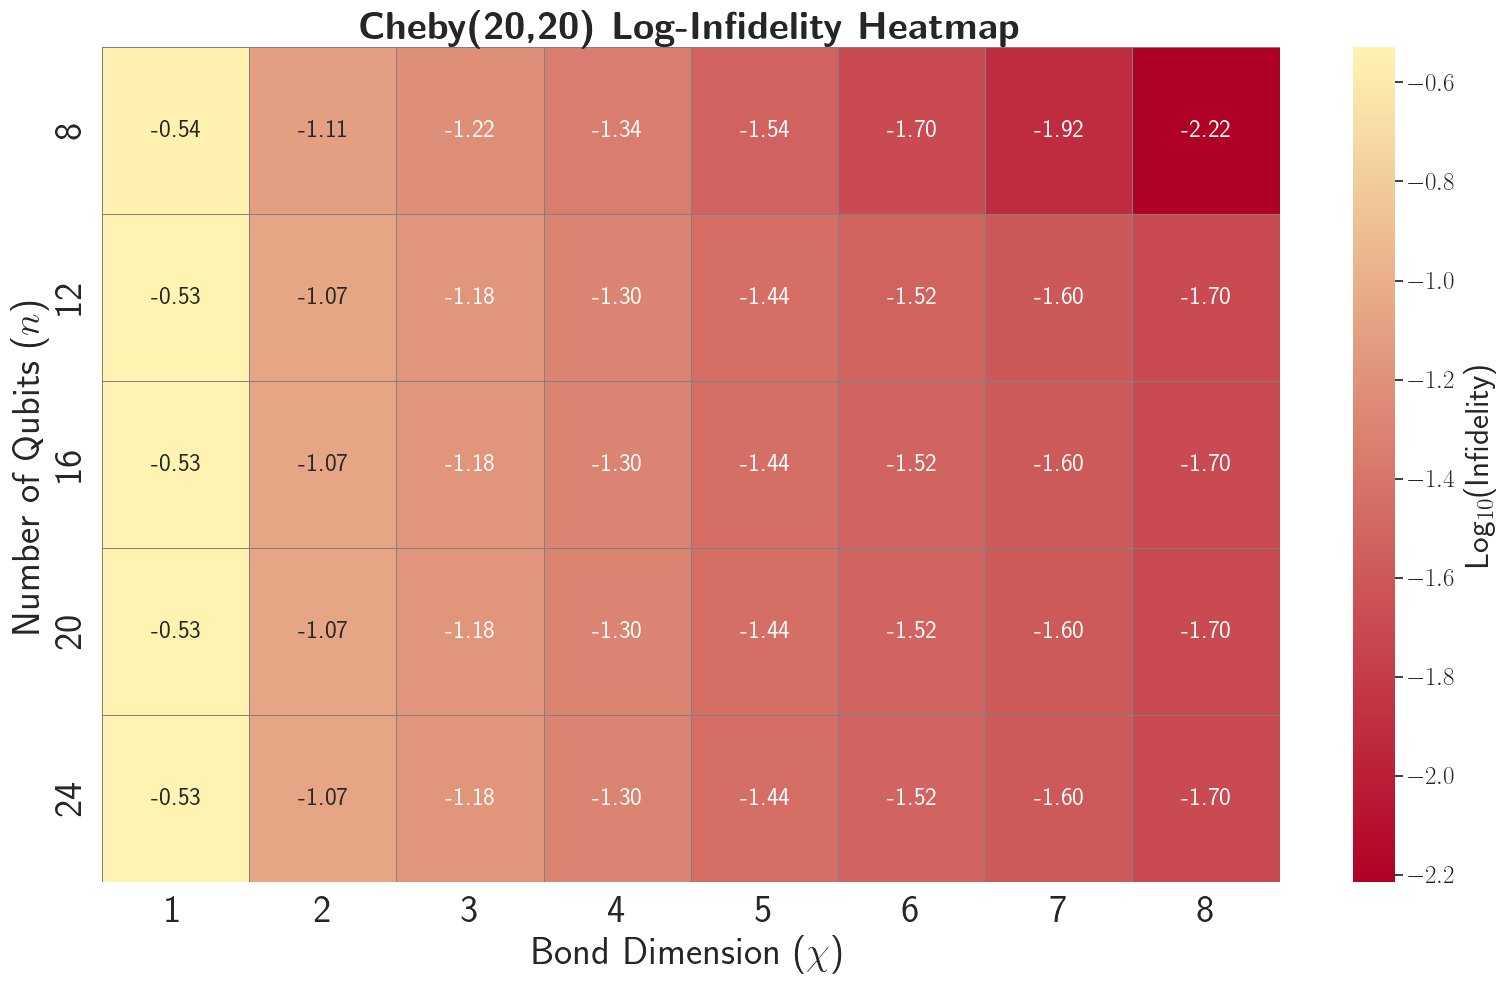

In [24]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

data_records = []
epsilon = 1e-16  # Set epsilon to 1e-16 as per your request

n_vals = [8,12,16,20,24]


for data, n in zip(cheby20_data, n_vals):
    for bond_dim, fidelity in data.items():
        infidelity = 1 - fidelity
        # Replace non-positive infidelities with epsilon
        infidelity = infidelity if infidelity > 0 else epsilon
        data_records.append({'n_val': n, 'bond_dim': bond_dim, 'infidelity': infidelity})

df = pd.DataFrame(data_records)

# Verify that all infidelity values are positive
non_positive = df[df['infidelity'] <= 0]
if not non_positive.empty:
    print("Non-positive infidelity values found and replaced with epsilon:")
    print(non_positive)
    df['infidelity'] = df['infidelity'].apply(lambda x: x if x > 0 else epsilon)
else:
    print("All infidelity values are positive.")

# Apply log10 transformation to infidelity
df['log_infidelity'] = np.log10(df['infidelity'])

# ================================
# Step 2: Create a Custom Colormap
# ================================

# Create a custom colormap transitioning from red to blue
# You can adjust the number of colors or specific shades as needed
custom_cmap = LinearSegmentedColormap.from_list('RedBlue', ['#B10026', '#FFF3B2'], N=256)
#custom_cmap = 'Wistia'
# ================================
# Step 3: Configure Matplotlib for LaTeX Fonts
# ================================

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 28,
        "axes.titlesize": 28,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
        "legend.fontsize": 22,
        "legend.title_fontsize": 22,
    })
# ================================
# Step 4: Pivot the DataFrame for Heatmap
# ================================

# Pivot the DataFrame to have n_val as rows and bond_dim as columns
heatmap_data = df.pivot(index='n_val', columns='bond_dim', values='log_infidelity')

# Sort the DataFrame for better visualization (optional)
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# ================================
# Step 5: Create the Heatmap
# ================================

# Set the style for seaborn
sns.set(style="white")

# Initialize the matplotlib figure
plt.figure(figsize=(16, 10))

# Create the heatmap
heatmap = sns.heatmap(
    heatmap_data,
    annot=True,                  # Annotate cells with data
    fmt=".2f",                   # Format annotations to two decimal places
    cmap=custom_cmap,            # Use the custom red-blue colormap
    cbar_kws={'label': r'$log_{10}$(Infidelity)'},  # Colorbar label with LaTeX
    linewidths=0.5,              # Line width between cells
    linecolor='gray',            # Line color between cells
    annot_kws={'size':18}
)

# ================================
# Step 6: Customize Axis Labels and Title
# ================================

# Set axis labels with LaTeX and font size 22
plt.xlabel(r'Bond Dimension ($\chi$)', fontsize=28)
plt.ylabel(r'Number of Qubits ($n$)', fontsize=28)

# Set the title with LaTeX and font size 22
plt.title(r'\textbf{Cheby(20,20) Log-Infidelity Heatmap}', fontsize=28)

# ================================
# Step 7: Customize Tick Labels
# ================================

# Set tick labels font size to 18
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel(r'Log$_{10}$(Infidelity)', fontsize=24)
cbar.ax.tick_params(labelsize=18)



# Optional: Reverse the y-axis to have higher n_val at the top
#plt.gca().invert_yaxis()

# ================================
# Step 8: Adjust Layout and Display
# ================================

plt.tight_layout()  # Adjust the padding between and around subplots

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Truncation Error\cheby20_scaling.png', dpi=300,transparent=True)

# Display the heatmap
plt.show()

In [53]:
def get_bond_data_random_state(vec,n=16):
    error = []


    #x_val#ues = np.linspace(-1, 1, 2**n)
    #f_values = f(x_values) / np.linalg.norm(f(x_values))
    f_values = vec
    f_tensor = f_values.reshape((2,)*n, order="F")

    MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(f_tensor)
    #MPS_exact = MatrixProductState(MPS_cores_exact)


        #print(f_values)
        #print(x_values)

    print(s_vals_exact)
    thresholds = find_max_nth_elements(s_vals_exact, max_n=9)
    print(thresholds)
    for i in thresholds:
        
    bond_dimensions, fidelities = threshold_analysis(s_vals_exact,f_values,f_tensor,thresholds[1:])
    bond_dimensions = np.array(bond_dimensions, dtype=int)
    fidelities = np.array(fidelities)


        # Find unique bond dimensions
    unique_bonds = np.unique(bond_dimensions)

        # Initialize a dictionary to store bond-fidelity pairs for the current s
    result_dict = {}

        # Iterate over each unique bond dimension
    for bond in unique_bonds:
                # Find indices where the bond dimension matches the current bond
        indices = np.where(bond_dimensions == bond)[0]
                
                # Get the corresponding fidelities and find the maximum
        max_fidelity = np.max(fidelities[indices])
                
                # Store the bond and its maximum fidelity in the dictionary
        result_dict[bond] = max_fidelity
                
        print(f'bond = {bond} and fidelity = {max_fidelity}')

            # Append the result dictionary for the current s to the data list
    error.append(result_dict)
    print(error)
    return error

In [54]:
def random_haar_state_vector(dim):
    """
    Generates a random state vector drawn from the Haar measure in a d-dimensional Hilbert space.

    Parameters:
    dim (int): The dimension of the Hilbert space.

    Returns:
    numpy.ndarray: A normalized complex state vector of shape (dim,).
    """
    # Step 1: Generate a vector with complex entries.
    # Real and imaginary parts are sampled from a standard normal distribution.
    real_part = np.random.normal(0, 1, dim)
    imag_part = np.random.normal(0, 1, dim)
    state_vector = real_part + 1j * imag_part

    # Step 2: Normalize the vector to have unit norm.
    norm = np.linalg.norm(state_vector)
    if norm == 0:
        raise ValueError("Generated a zero vector; retrying might be necessary.")
    normalized_state_vector = state_vector / norm

    return normalized_state_vector